In [21]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from datetime import datetime
import logging
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
import gc  # for garbage collection
import os

#import necessary packages 
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from datetime import datetime
from tqdm.auto import tqdm
from typing import Tuple, Optional,List, Dict
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.stats import pearsonr, spearmanr
from scipy.interpolate import RectBivariateSpline
import xesmf as xe
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.gridspec import GridSpec
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings

In [22]:
#load in the data using xarray 
merra2_data=xr.open_dataset("merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc", engine="netcdf4")
nldas_data= xr.open_dataset("nldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
fldas_data= xr.open_dataset("fldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
gldas_data= xr.open_dataset("gldas_data_2013-01-01_2023-12-31.nc", engine="netcdf4")
era5_data=xr.open_dataset('/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',engine='cfgrib')

#create dataset dictionary 

datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

# Define variable names for each dataset
var_names = {
    'MERRA2': 'SFMC',  # Surface soil moisture content
    'NLDAS': 'SoilM_0_10cm',
    'FLDAS': 'SoilMoi00_10cm_tavg',
    'GLDAS': 'SoilMoi0_10cm_inst',
    'ERA5': 'swvl1'  # Volumetric soil water layer 1
}

coord_mapping = {
    'NLDAS': {'lat': 'lat', 'lon': 'lon'},
    'GLDAS': {'lat': 'lat', 'lon': 'lon'},
    'FLDAS': {'lat': 'Y', 'lon': 'X'},
    'ERA5': {'lat': 'latitude', 'lon': 'longitude'},
    'MERRA2': {'lat': 'lat', 'lon': 'lon'}
}


Normalization stats for MERRA2:
Original mean: 0.2624, std: 0.0585
Normalized mean: -0.0000, std: 1.0000

Normalization stats for NLDAS:
Original mean: 29.3776, std: 7.0058
Normalized mean: 0.0000, std: 1.0001

Normalization stats for FLDAS:
Original mean: 0.3622, std: 0.0497
Normalized mean: -0.0000, std: 1.0001

Normalization stats for GLDAS:
Original mean: 31.4795, std: 6.4977
Normalized mean: -0.0000, std: 1.0000

Normalization stats for ERA5:
Original mean: 0.3042, std: 0.0944
Normalized mean: 0.0000, std: 1.0000

=== Data Diagnostics Report ===

--------------------
MERRA2
--------------------
Shape: 132 × 10 × 13
Memory Usage: 0.13 MB
Value Range: -3.0492 to 2.4703
Mean ± Std: -0.0000 ± 1.0000
Median (IQR): 0.0376 (1.3878)
Missing Data: 0.00%
Outliers: 0.17%

--------------------
NLDAS
--------------------
Shape: 132 × 36 × 63
Memory Usage: 2.28 MB
Value Range: -3.7698 to 2.6010
Mean ± Std: 0.0000 ± 1.0001
Median (IQR): -0.1468 (1.1717)
Missing Data: 10.49%
Outliers: 2.84%

---

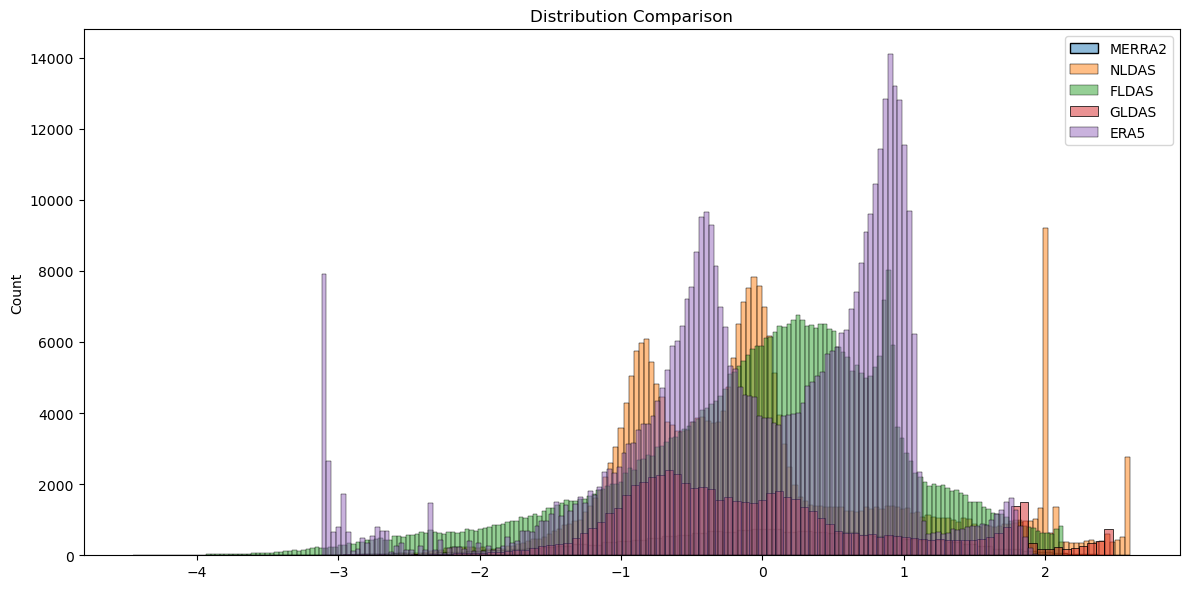


=== Cross-Dataset Comparison ===
         Mean     Std  Missing_Percentage  Outlier_Percentage
Dataset                                                      
MERRA2   -0.0  1.0000              0.0000              0.1690
NLDAS     0.0  1.0001             10.4938              2.8422
FLDAS    -0.0  1.0001             10.4641              3.1350
GLDAS    -0.0  1.0000             10.2431              2.1159
ERA5      0.0  1.0000              3.3152              4.0174


In [10]:
import xarray as xr
import numpy as np
import pandas as pd
from typing import Dict, Union
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset configurations
DATA_CONFIG = {
    'MERRA2': {
        'path': "merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc",
        'var_name': 'SFMC',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'NLDAS': {
        'path': "nldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilM_0_10cm',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'FLDAS': {
        'path': "fldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi00_10cm_tavg',
        'coords': {'lat': 'Y', 'lon': 'X'},
        'engine': 'netcdf4'
    },
    'GLDAS': {
        'path': "gldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi0_10cm_inst',
        'coords': {'lat': 'lat', 'lon': 'lon'},
        'engine': 'netcdf4'
    },
    'ERA5': {
        'path': '/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',
        'var_name': 'swvl1',
        'coords': {'lat': 'latitude', 'lon': 'longitude'},
        'engine': 'cfgrib'
    }
}

def load_datasets() -> Dict[str, xr.Dataset]:
    """Load all datasets using the configuration dictionary."""
    return {name: xr.open_dataset(config['path'], engine=config['engine'])
            for name, config in DATA_CONFIG.items()}

def normalize_datasets(datasets_dict: Dict[str, xr.Dataset]) -> Dict[str, xr.DataArray]:
    """
    Normalize each dataset by removing the mean and dividing by the standard deviation.
    
    Parameters:
    -----------
    datasets_dict : Dict[str, xr.Dataset]
        Dictionary of datasets with model names as keys
        
    Returns:
    --------
    Dict[str, xr.DataArray]
        Dictionary of normalized datasets
    """
    normalized_datasets = {}
    
    for name, data in datasets_dict.items():
        try:
            # Get the variable name from config
            var_name = DATA_CONFIG[name]['var_name']
            
            # Extract the data array
            data_array = data[var_name]
            
            # Calculate mean and standard deviation along all dimensions
            mean = data_array.mean()
            std = data_array.std()
            
            # Normalize the data
            normalized_data = (data_array - mean) / std
            
            # Store the normalized dataset
            normalized_datasets[name] = normalized_data
            
            # Print statistics for verification
            print(f"\nNormalization stats for {name}:")
            print(f"Original mean: {mean.values:.4f}, std: {std.values:.4f}")
            print(f"Normalized mean: {normalized_data.mean().values:.4f}, std: {normalized_data.std().values:.4f}")
            
        except Exception as e:
            print(f"Error normalizing {name}: {str(e)}")
            continue
    
    return normalized_datasets

def check_data_properties(datasets_dict: Dict[str, Union[xr.Dataset, xr.DataArray]], 
                         plot_distributions: bool = True) -> pd.DataFrame:
    """
    Comprehensive diagnostic check of soil moisture datasets.
    
    Parameters:
    -----------
    datasets_dict : Dict
        Dictionary of datasets with model names as keys
    plot_distributions : bool
        Whether to plot distribution visualizations
        
    Returns:
    --------
    pd.DataFrame
        Summary statistics for all datasets
    """
    stats_list = []
    
    if plot_distributions:
        plt.figure(figsize=(12, 6))
        plt.title('Soil Moisture Data Distributions')
    
    print("\n=== Data Diagnostics Report ===")
    
    for name, data in datasets_dict.items():
        print(f"\n{'-'*20}\n{name}\n{'-'*20}")
        
        try:
            var_name = DATA_CONFIG[name]['var_name']
            data_array = data[var_name] if isinstance(data, xr.Dataset) else data
            
            if not isinstance(data_array, xr.DataArray):
                raise TypeError(f"Expected xarray.DataArray, got {type(data_array)}")
            
            values = data_array.values
            flattened = values.flatten()
            valid_values = flattened[~np.isnan(flattened)]
            
            # Calculate statistics
            stats = {
                'Dataset': name,
                **{metric: func(valid_values) for metric, func in {
                    'Mean': np.mean,
                    'Std': np.std,
                    'Min': np.min,
                    'Max': np.max
                }.items()},
                'NaN_Count': np.sum(np.isnan(flattened)),
                'Total_Values': len(flattened),
                'Valid_Values': len(valid_values),
                'Missing_Percentage': (np.sum(np.isnan(flattened)) / len(flattened)) * 100,
                'Dimensions': ' × '.join(map(str, values.shape)),
                'Memory_MB': values.nbytes / (1024 * 1024)
            }
            
            # Add quartile statistics
            quartiles = np.percentile(valid_values, [25, 50, 75])
            stats.update({
                'Q1': quartiles[0],
                'Median': quartiles[1],
                'Q3': quartiles[2],
                'IQR': quartiles[2] - quartiles[0]
            })
            
            # Calculate outliers
            iqr = stats['IQR']
            bounds = (stats['Q1'] - (1.5 * iqr), stats['Q3'] + (1.5 * iqr))
            outliers = np.sum((valid_values < bounds[0]) | (valid_values > bounds[1]))
            stats.update({
                'Outlier_Count': outliers,
                'Outlier_Percentage': (outliers / len(valid_values)) * 100
            })
            
            stats_list.append(stats)
            
            # Print report
            print(f"Shape: {stats['Dimensions']}")
            print(f"Memory Usage: {stats['Memory_MB']:.2f} MB")
            print(f"Value Range: {stats['Min']:.4f} to {stats['Max']:.4f}")
            print(f"Mean ± Std: {stats['Mean']:.4f} ± {stats['Std']:.4f}")
            print(f"Median (IQR): {stats['Median']:.4f} ({stats['IQR']:.4f})")
            print(f"Missing Data: {stats['Missing_Percentage']:.2f}%")
            print(f"Outliers: {stats['Outlier_Percentage']:.2f}%")
            
            if plot_distributions:
                sns.histplot(valid_values, label=name, alpha=0.5)
                
        except Exception as e:
            print(f"Error processing {name}: {str(e)}")
            continue
    
    if plot_distributions:
        plt.title('Distribution Comparison')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    summary_df = pd.DataFrame(stats_list).set_index('Dataset')
    
    print("\n=== Cross-Dataset Comparison ===")
    print(summary_df[['Mean', 'Std', 'Missing_Percentage', 'Outlier_Percentage']].round(4))
    
    return summary_df

# Example usage:
if __name__ == "__main__":
    # Load original datasets
    datasets = load_datasets()
    
    # Normalize datasets
    normalized_datasets = normalize_datasets(datasets)
    
    # Optionally, you can check the distributions of normalized data
    summary_stats = check_data_properties(normalized_datasets, plot_distributions=True)
    


Normalization stats for MERRA2:
Original mean: 0.2624, std: 0.0585
Normalized mean: -0.0000, std: 1.0000

Normalization stats for NLDAS:
Original mean: 29.3776, std: 7.0058
Normalized mean: 0.0000, std: 1.0001

Normalization stats for FLDAS:
Original mean: 0.3622, std: 0.0497
Normalized mean: -0.0000, std: 1.0001

Normalization stats for GLDAS:
Original mean: 31.4795, std: 6.4977
Normalized mean: -0.0000, std: 1.0000

Normalization stats for ERA5:
Original mean: 0.3042, std: 0.0944
Normalized mean: 0.0000, std: 1.0000


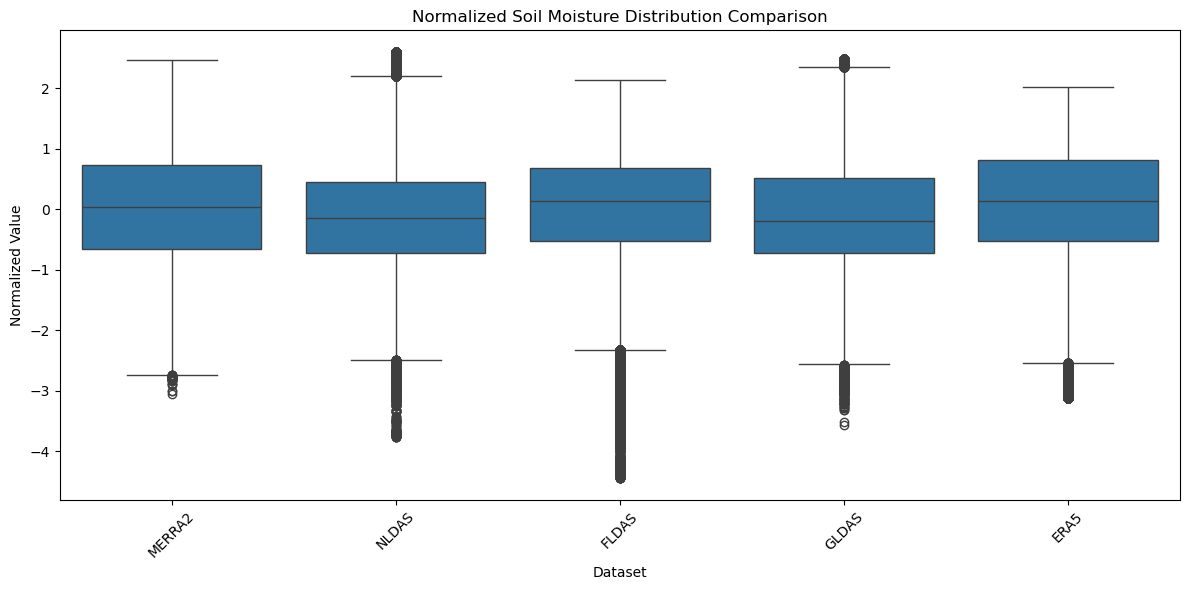

In [11]:
#plot box plots for each normalized dataset 

def create_boxplot_all_datasets(datasets, normalized=False):
    """
    Create a box plot comparing all soil moisture datasets.
    
    Parameters:
    -----------
    datasets : dict
        Dictionary containing dataset names and their corresponding xarray Datasets
    normalized : bool
        Whether the data is normalized (affects title and y-axis label)
    """
    # Prepare data for plotting
    plot_data = []
    
    for name, data in datasets.items():
        if isinstance(data, xr.Dataset):
            var_name = DATA_CONFIG[name]['var_name']
            values = data[var_name].values.flatten()
        else:  # For normalized data (xr.DataArray)
            values = data.values.flatten()
            
        valid_values = values[~np.isnan(values)]
        
        # Create DataFrame entries for this dataset
        plot_data.extend({
            'Dataset': name,
            'Value': val
        } for val in valid_values)
    
    # Convert to DataFrame
    df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='Dataset', y='Value')
    
    title = 'Normalized Soil Moisture Distribution Comparison' if normalized else 'Soil Moisture Distribution Comparison'
    plt.title(title)
    plt.ylabel('Normalized Value' if normalized else 'Soil Moisture')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Load original datasets
    datasets = load_datasets()
    
    # Normalize datasets
    normalized_datasets = normalize_datasets(datasets)
    
    # Create boxplot for normalized data
    create_boxplot_all_datasets(normalized_datasets, normalized=True)

In [12]:
from typing import Dict, Tuple, Optional
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xesmf as xe
import gc
from contextlib import contextmanager

# Configuration dictionary remains the same
DATA_CONFIG = {
    'MERRA2': {
        'path': "merra2_data/merra2_monthly_soil_moisture_2013-01_2023-12.nc",
        'var_name': 'SFMC',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'NLDAS': {
        'path': "nldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilM_0_10cm',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'FLDAS': {
        'path': "fldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi00_10cm_tavg',
        'coords': {'lat': 'Y', 'lon': 'X'}
    },
    'GLDAS': {
        'path': "gldas_data_2013-01-01_2023-12-31.nc",
        'var_name': 'SoilMoi0_10cm_inst',
        'coords': {'lat': 'lat', 'lon': 'lon'}
    },
    'ERA5': {
        'path': '/Users/alicemonroe/Downloads/48d4a4137072514563387dd5691e5614.grib',
        'var_name': 'swvl1',
        'coords': {'lat': 'latitude', 'lon': 'longitude'}
    }
}

@contextmanager
def dataset_context(path: str, engine: Optional[str] = None):
    """Context manager for safely opening and closing datasets"""
    ds = None
    try:
        ds = xr.open_dataset(path, engine=engine)
        yield ds
    finally:
        if ds is not None:
            ds.close()
        gc.collect()

def load_single_dataset(name: str, config: dict) -> xr.Dataset:
    """Load a single dataset with proper resource management"""
    engine = 'cfgrib' if config['path'].endswith('.grib') else None
    with dataset_context(config['path'], engine=engine) as ds:
        # Load only the necessary variable and create a copy
        var_name = config['var_name']
        coords = config['coords']
        data = ds[var_name].copy()
        
        # Rename coordinates if needed
        if coords['lat'] != 'lat' or coords['lon'] != 'lon':
            data = data.rename({
                coords['lat']: 'lat',
                coords['lon']: 'lon'
            })
        
        return data

def create_land_mask(era5_data: xr.DataArray) -> xr.DataArray:
    """Create a land mask using ERA5 data"""
    try:
        # Use first time step to create mask
        first_step = era5_data.isel(time=0)
        mask = ~np.isnan(first_step) & (first_step != 0)
        
        print(f"Land points: {mask.sum().values}")
        print(f"Total points: {mask.size}")
        print(f"Land percentage: {(mask.sum().values / mask.size * 100):.1f}%")
        
        return mask
    except Exception as e:
        print(f"Error creating land mask: {str(e)}")
        return None

def process_chunk(chunk1: np.ndarray, chunk2: np.ndarray) -> float:
    """Process a single chunk of data for correlation"""
    mask = ~(np.isnan(chunk1) | np.isnan(chunk2))
    if np.sum(mask) > 1:
        return np.corrcoef(chunk1[mask], chunk2[mask])[0,1]
    return np.nan

def calculate_correlation(data1: xr.DataArray, data2: xr.DataArray, 
                        chunk_size: int = 100) -> float:
    """Calculate correlation with chunking"""
    correlations = []
    
    # Process data in chunks to reduce memory usage
    for i in range(0, data1.shape[1], chunk_size):
        for j in range(0, data1.shape[2], chunk_size):
            chunk1 = data1[:, i:i+chunk_size, j:j+chunk_size].values
            chunk2 = data2[:, i:i+chunk_size, j:j+chunk_size].values
            
            # Reshape chunks to 2D arrays (time, space)
            chunk1_2d = chunk1.reshape(chunk1.shape[0], -1)
            chunk2_2d = chunk2.reshape(chunk2.shape[0], -1)
            
            # Calculate correlations for each spatial point in chunk
            for k in range(chunk1_2d.shape[1]):
                corr = process_chunk(chunk1_2d[:, k], chunk2_2d[:, k])
                if not np.isnan(corr):
                    correlations.append(corr)
    
    return np.mean(correlations) if correlations else np.nan

def regrid_and_process_dataset(data: xr.DataArray, reference: xr.DataArray, land_mask: xr.DataArray) -> xr.DataArray:
    """Regrid a single dataset and process it"""
    try:
        # Create regridder
        regridder = xe.Regridder(data, reference, 'bilinear', periodic=True)
        
        # Regrid
        regridded = regridder(data)
        
        # Apply mask and normalize
        masked = regridded.where(land_mask)
        normalized = (masked - masked.mean()) / masked.std()
        
        # Clean up by deleting regridder (no need for clean_weight_file)
        del regridder
        gc.collect()
        
        return normalized
        
    except Exception as e:
        raise Exception(f"Error in regridding and processing: {str(e)}")

def regrid_normalize_and_correlate(reference_dataset: xr.DataArray, 
                                 datasets: Dict[str, xr.DataArray]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Regrid datasets and compute correlations with memory optimization"""
    names = list(datasets.keys())
    n_datasets = len(names)
    
    # Initialize matrices
    correlation_matrix = np.zeros((n_datasets, n_datasets))
    shared_variance_matrix = np.zeros((n_datasets, n_datasets))
    
    # Process each dataset
    for i, name1 in enumerate(names):
        for j, name2 in enumerate(names[i:], i):
            if name1 == name2:
                correlation_matrix[i,j] = correlation_matrix[j,i] = 1.0
                shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = 100.0
                continue
                
            try:
                print(f"\nProcessing {name1} vs {name2}")
                
                # Calculate correlation
                corr = calculate_correlation(datasets[name1], datasets[name2])
                
                # Store results
                correlation_matrix[i,j] = correlation_matrix[j,i] = corr
                shared_variance = (corr ** 2) * 100
                shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = shared_variance
                
                print(f"Correlation: {corr:.4f}")
                print(f"Shared variance: {shared_variance:.1f}%")
                
            except Exception as e:
                print(f"Error processing {name1} and {name2}: {str(e)}")
                correlation_matrix[i,j] = correlation_matrix[j,i] = np.nan
                shared_variance_matrix[i,j] = shared_variance_matrix[j,i] = np.nan
    
    # Create DataFrames
    corr_df = pd.DataFrame(correlation_matrix, index=names, columns=names)
    r2_df = pd.DataFrame(shared_variance_matrix, index=names, columns=names)
    
    return corr_df, r2_df

def plot_matrices(correlation_matrix: pd.DataFrame, shared_variance_matrix: pd.DataFrame) -> None:
    """Create and save visualization of correlation and shared variance matrices"""
    # Set up the plot style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 8))
    fig.patch.set_facecolor('white')
    
    # Create grid for subplots
    gs = plt.GridSpec(2, 4, figure=fig)
    
    # Create main correlation matrix plot
    ax1 = fig.add_subplot(gs[:, :2])
    
    # Create custom colormap from white to blue
    colors = ['#ffffff', '#e3f2fd', '#90caf9', '#42a5f5', '#1976d2', '#0d47a1']
    n_bins = 100
    cmap_corr = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", colors, N=n_bins)
    
    # Plot correlation heatmap
    im1 = ax1.imshow(correlation_matrix.values, 
                     cmap=cmap_corr,
                     vmin=0,  # Since all correlations are positive
                     vmax=1,
                     aspect='equal')
    
    # Add correlation values as text
    for i in range(len(correlation_matrix)):
        for j in range(len(correlation_matrix)):
            value = correlation_matrix.iloc[i, j]
            color = 'white' if value >= 0.7 else 'black'
            weight = 'bold' if value >= 0.7 else 'normal'
            text = ax1.text(j, i, f"{value:.3f}",
                          ha='center',
                          va='center',
                          color=color,
                          fontweight=weight,
                          fontsize=10)
    
    # Customize correlation plot
    ax1.set_title('Soil Moisture Dataset Correlations', pad=20, fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(correlation_matrix.columns)))
    ax1.set_yticks(range(len(correlation_matrix.index)))
    ax1.set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
    ax1.set_yticklabels(correlation_matrix.index)
    
    # Add colorbar with custom ticks
    cbar1 = plt.colorbar(im1, ax=ax1, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cbar1.ax.set_ylabel('Correlation Coefficient', rotation=270, labelpad=20)
    
    # Create shared variance heatmap
    ax2 = fig.add_subplot(gs[:, 2:])
    
    # Custom colormap for variance
    colors_var = ['#ffffff', '#fff3e0', '#ffcc80', '#ffb74d', '#ff9800', '#f57c00']
    cmap_var = plt.matplotlib.colors.LinearSegmentedColormap.from_list("", colors_var, N=n_bins)
    
    im2 = ax2.imshow(shared_variance_matrix.values,
                     cmap=cmap_var,
                     vmin=0,
                     vmax=100,
                     aspect='equal')
    
    # Add shared variance values as text
    for i in range(len(shared_variance_matrix)):
        for j in range(len(shared_variance_matrix)):
            value = shared_variance_matrix.iloc[i, j]
            color = 'white' if value >= 50 else 'black'
            weight = 'bold' if value >= 50 else 'normal'
            text = ax2.text(j, i, f"{value:.1f}%",
                          ha='center',
                          va='center',
                          color=color,
                          fontweight=weight,
                          fontsize=10)
    
    # Customize shared variance plot
    ax2.set_title('Shared Variance Between Datasets', pad=20, fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(shared_variance_matrix.columns)))
    ax2.set_yticks(range(len(shared_variance_matrix.index)))
    ax2.set_xticklabels(shared_variance_matrix.columns, rotation=45, ha='right')
    ax2.set_yticklabels(shared_variance_matrix.index)
    
    # Add colorbar with custom ticks
    cbar2 = plt.colorbar(im2, ax=ax2, ticks=[0, 20, 40, 60, 80, 100])
    cbar2.ax.set_ylabel('Shared Variance (%)', rotation=270, labelpad=20)
    
    # Add a text box with key findings
    key_findings = (
        "Key Findings:\n"
        "• Strongest correlation: FLDAS-GLDAS (0.718)\n"
        "• Weakest correlation: ERA5-NLDAS (0.431)\n"
        "• All correlations are positive (0.431-0.718)\n"
        "• MERRA2 shows consistent moderate correlations"
    )
    
    plt.figtext(0.02, -0.05, key_findings,
                fontsize=10,
                bbox=dict(facecolor='white',
                         edgecolor='gray',
                         alpha=0.8,
                         pad=10),
                transform=ax1.transAxes)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('soil_moisture_analysis.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white')
    plt.close()

def main():
    """Main function with improved memory management"""
    try:
        # Load ERA5 first as reference
        print("Loading ERA5 dataset...")
        era5_data = load_single_dataset('ERA5', DATA_CONFIG['ERA5'])
        
        # Create land mask
        land_mask = create_land_mask(era5_data)
        if land_mask is None:
            raise ValueError("Failed to create land mask")
            
        # Apply mask to ERA5 and normalize
        era5_masked = era5_data.where(land_mask)
        era5_normalized = (era5_masked - era5_masked.mean()) / era5_masked.std()
        
        # Process other datasets one at a time
        processed_datasets = {'ERA5': era5_normalized}
        
        for name, config in DATA_CONFIG.items():
            if name == 'ERA5':
                continue
                
            print(f"\nProcessing {name}...")
            try:
                # Load and process dataset
                data = load_single_dataset(name, config)
                
                # Regrid and process
                processed = regrid_and_process_dataset(data, era5_data, land_mask)
                processed_datasets[name] = processed
                
                print(f"Successfully processed {name}")
                
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                continue
            
            # Force garbage collection
            gc.collect()
        
        # Calculate correlations
        print("\nCalculating correlations...")
        correlation_matrix, shared_variance_matrix = regrid_normalize_and_correlate(
            era5_normalized, processed_datasets
        )
        
        # Create visualizations
        print("\nCreating visualizations...")
        plot_matrices(correlation_matrix, shared_variance_matrix)
        
        # Save results
        correlation_matrix.to_csv('correlation_matrix.csv')
        shared_variance_matrix.to_csv('shared_variance_matrix.csv')
        print("\nAnalysis complete. Results saved to CSV files.")
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
    
    finally:
        # Clean up
        gc.collect()

if __name__ == "__main__":
    main()

Loading ERA5 dataset...
Land points: 3558
Total points: 3680
Land percentage: 96.7%

Processing MERRA2...
Successfully processed MERRA2

Processing NLDAS...
Successfully processed NLDAS

Processing FLDAS...
Successfully processed FLDAS

Processing GLDAS...
Successfully processed GLDAS

Calculating correlations...

Processing ERA5 vs MERRA2


/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/climate_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation: 0.6932
Shared variance: 48.0%

Processing ERA5 vs NLDAS
Correlation: 0.4310
Shared variance: 18.6%

Processing ERA5 vs FLDAS
Correlation: 0.5888
Shared variance: 34.7%

Processing ERA5 vs GLDAS
Correlation: 0.5288
Shared variance: 28.0%

Processing MERRA2 vs NLDAS
Correlation: 0.4839
Shared variance: 23.4%

Processing MERRA2 vs FLDAS
Correlation: 0.6463
Shared variance: 41.8%

Processing MERRA2 vs GLDAS
Correlation: 0.6092
Shared variance: 37.1%

Processing NLDAS vs FLDAS
Correlation: 0.6705
Shared variance: 45.0%

Processing NLDAS vs GLDAS
Correlation: 0.6764
Shared variance: 45.8%

Processing FLDAS vs GLDAS
Correlation: 0.7177
Shared variance: 51.5%

Creating visualizations...

Analysis complete. Results saved to CSV files.



Processing: MERRA2_vs_NLDAS

Processing: MERRA2_vs_FLDAS

Processing: MERRA2_vs_GLDAS

Processing: MERRA2_vs_ERA5

Processing: NLDAS_vs_FLDAS

Processing: NLDAS_vs_GLDAS

Processing: NLDAS_vs_ERA5

Processing: FLDAS_vs_GLDAS

Processing: FLDAS_vs_ERA5

Processing: GLDAS_vs_ERA5


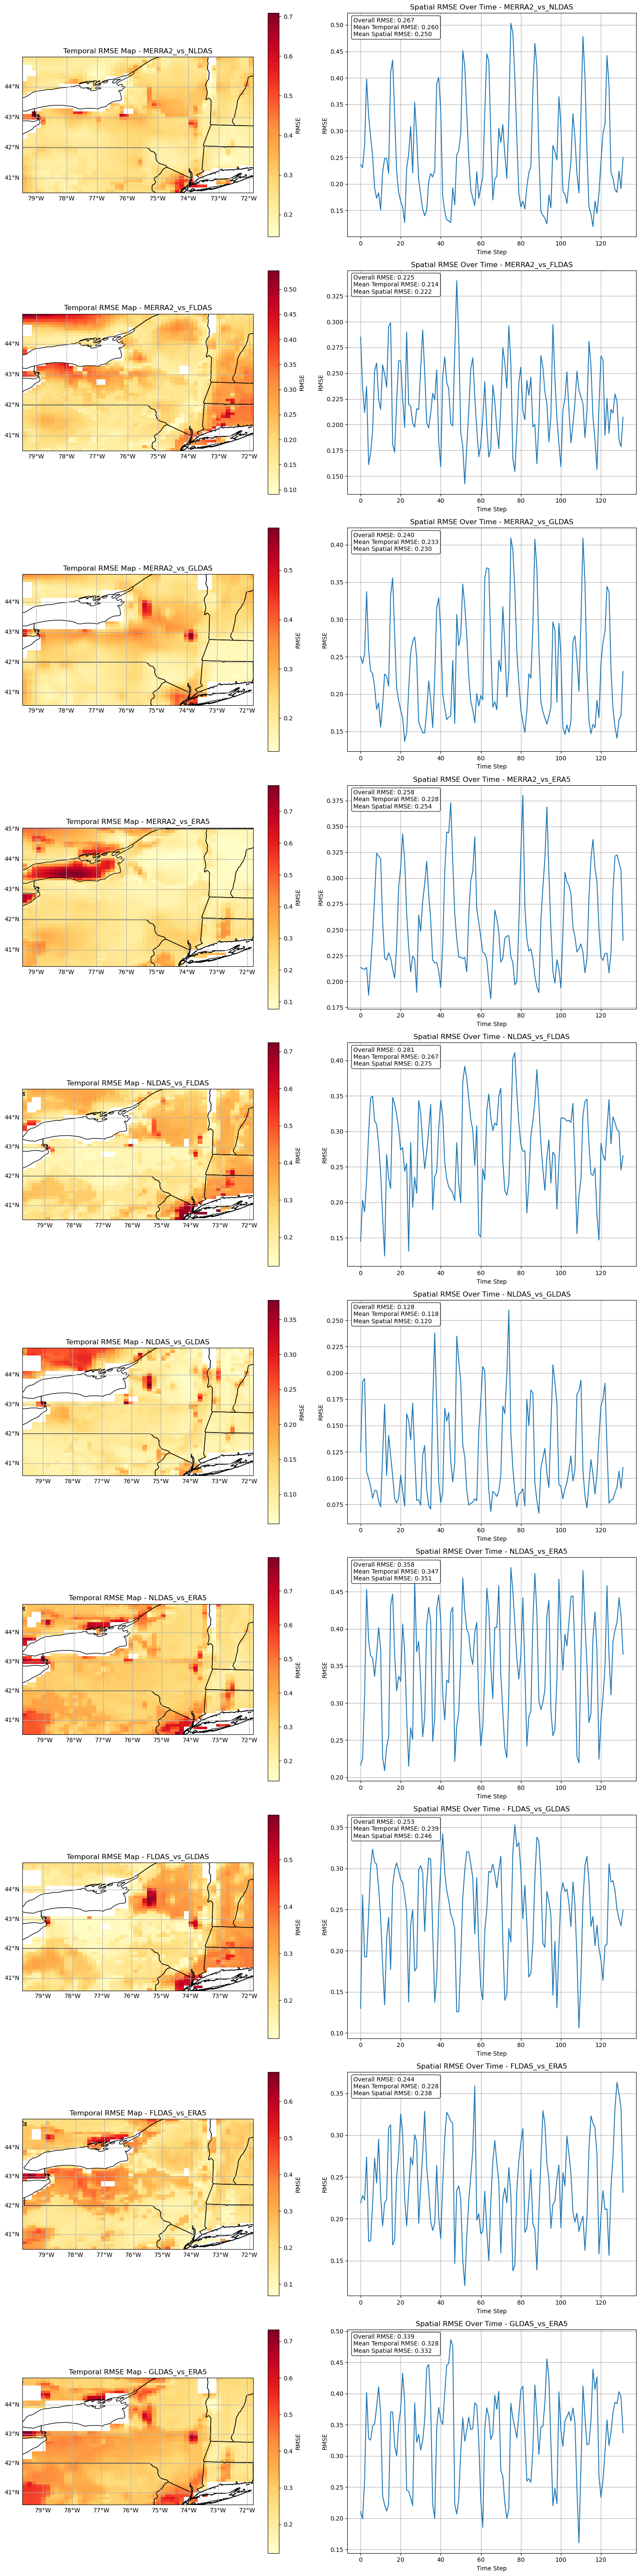

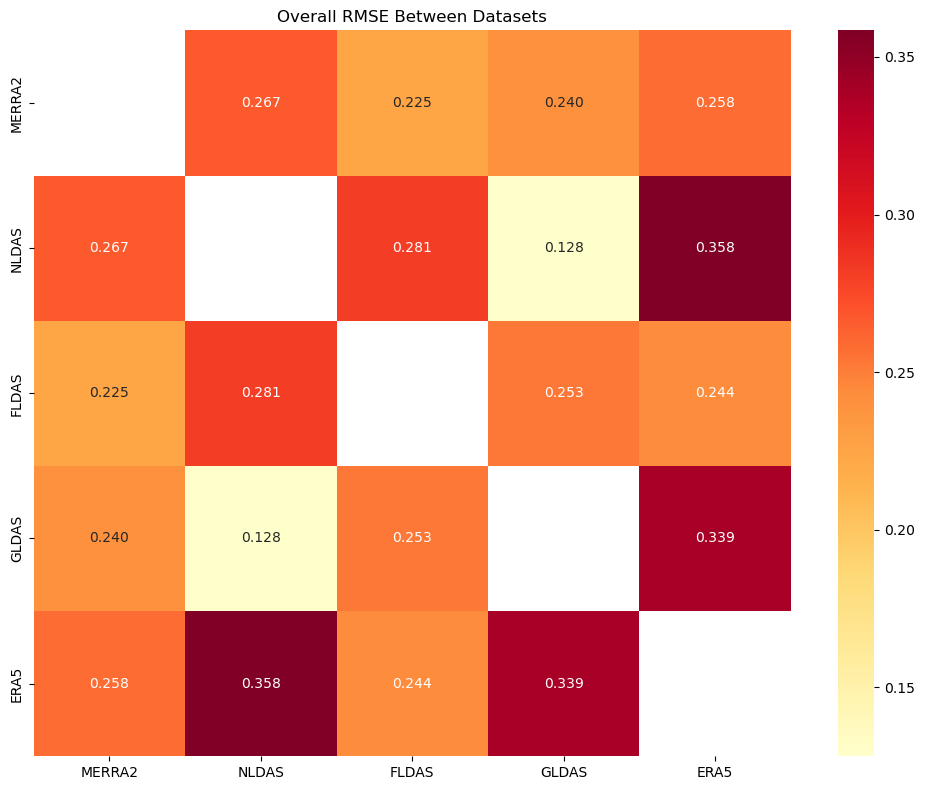

In [17]:
#calculate rmse and plot 
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from typing import Dict, Tuple, Union

# Create processed datasets dictionary
processed_datasets = {}
for name, ds in datasets.items():
    var_name = var_names[name]
    if var_name in ds:
        processed_datasets[name] = ds[[var_name]]

# Function definitions
def normalize_soil_moisture(ds, var_name):
    var = ds[var_name]
    valid_data = var.values[~np.isnan(var.values)]
    vmin = np.percentile(valid_data, 1)
    vmax = np.percentile(valid_data, 99)
    normalized = (var - vmin) / (vmax - vmin)
    normalized = normalized.clip(0, 1)
    return ds.assign({var_name: normalized})

def get_coordinate_names(ds):
    lat_names = ['latitude', 'lat', 'Y']
    lon_names = ['longitude', 'lon', 'X']
    all_names = list(ds.coords) + list(ds.dims)
    lat_name = next((name for name in lat_names if name in all_names), None)
    lon_name = next((name for name in lon_names if name in all_names), None)
    if lat_name is None or lon_name is None:
        raise ValueError(f"Could not find coordinates in: {all_names}")
    return lat_name, lon_name

def calculate_rmse(original, regridded, debug=True):
    if isinstance(original, xr.DataArray):
        original = original.to_dataset()
    if isinstance(regridded, xr.DataArray):
        regridded = regridded.to_dataset()
    
    orig_lat_name, orig_lon_name = get_coordinate_names(original)
    regrid_lat_name, regrid_lon_name = get_coordinate_names(regridded)
    
    # Time coordinate handling
    time_names = ['time', 'valid_time']
    orig_time_name = next((name for name in time_names if name in original.dims), None)
    regrid_time_name = next((name for name in time_names if name in regridded.dims), None)
    
    if orig_time_name and regrid_time_name:
        original = original.assign_coords({
            orig_time_name: pd.to_datetime(original[orig_time_name].values)
        })
        regridded = regridded.assign_coords({
            regrid_time_name: pd.to_datetime(regridded[regrid_time_name].values)
        })
        
        orig_times = original[orig_time_name].values
        regrid_times = regridded[regrid_time_name].values
        
        if len(orig_times) <= len(regrid_times):
            reference_times = orig_times
            regridded = regridded.sel({regrid_time_name: reference_times}, method='nearest')
            common_times = reference_times
        else:
            reference_times = regrid_times
            original = original.sel({orig_time_name: reference_times}, method='nearest')
            common_times = reference_times
    
    # Create common grid
    new_lat = np.linspace(
        max(original[orig_lat_name].min(), regridded[regrid_lat_name].min()),
        min(original[orig_lat_name].max(), regridded[regrid_lat_name].max()),
        50
    )
    new_lon = np.linspace(
        max(original[orig_lon_name].min(), regridded[regrid_lon_name].min()),
        min(original[orig_lon_name].max(), regridded[regrid_lon_name].max()),
        50
    )
    
    # Interpolate
    original_interp = original.interp({orig_lat_name: new_lat, orig_lon_name: new_lon})
    regridded_interp = regridded.interp({regrid_lat_name: new_lat, regrid_lon_name: new_lon})
    
    # Get variables
    orig_var = list(original.data_vars)[0]
    regrid_var = list(regridded.data_vars)[0]
    
    # Normalize
    original_interp = normalize_soil_moisture(original_interp, orig_var)
    regridded_interp = normalize_soil_moisture(regridded_interp, regrid_var)
    
    # Calculate metrics
    diff = original_interp[orig_var].values - regridded_interp[regrid_var].values
    mask = ~np.isnan(diff)
    overall_rmse = np.sqrt(np.mean(diff[mask]**2))
    
    temporal_rmse = np.zeros((len(new_lat), len(new_lon)))
    spatial_rmse = np.zeros(len(common_times))
    
    for i in range(len(new_lat)):
        for j in range(len(new_lon)):
            mask = ~np.isnan(original_interp[orig_var].values[:, i, j]) & ~np.isnan(regridded_interp[regrid_var].values[:, i, j])
            if np.any(mask):
                temporal_rmse[i, j] = np.sqrt(np.mean((
                    original_interp[orig_var].values[:, i, j][mask] - 
                    regridded_interp[regrid_var].values[:, i, j][mask]
                )**2))
            else:
                temporal_rmse[i, j] = np.nan
    
    for t in range(len(common_times)):
        mask = ~np.isnan(original_interp[orig_var].values[t]) & ~np.isnan(regridded_interp[regrid_var].values[t])
        if np.any(mask):
            spatial_rmse[t] = np.sqrt(np.mean((
                original_interp[orig_var].values[t][mask] - 
                regridded_interp[regrid_var].values[t][mask]
            )**2))
        else:
            spatial_rmse[t] = np.nan
    
    return {
        'overall_rmse': overall_rmse,
        'temporal_rmse': temporal_rmse,
        'spatial_rmse': spatial_rmse,
        'temporal_mean_rmse': np.nanmean(temporal_rmse),
        'spatial_mean_rmse': np.nanmean(spatial_rmse),
        'lat': new_lat,
        'lon': new_lon,
        'variables_compared': (orig_var, regrid_var),
        'n_timesteps': len(common_times)
    }

# Calculate RMSE for all pairs
rmse_results = {}
dataset_names = list(processed_datasets.keys())
for i in range(len(dataset_names)):
    for j in range(i + 1, len(dataset_names)):
        name1, name2 = dataset_names[i], dataset_names[j]
        pair_name = f"{name1}_vs_{name2}"
        print(f"\nProcessing: {pair_name}")
        rmse_stats = calculate_rmse(processed_datasets[name1], processed_datasets[name2])
        rmse_results[pair_name] = rmse_stats

# Plot results
fig = plt.figure(figsize=(15, 6 * len(rmse_results)))
plot_idx = 0

for pair_name, results in rmse_results.items():
    # Map subplot
    ax1 = fig.add_subplot(len(rmse_results), 2, plot_idx * 2 + 1, projection=ccrs.PlateCarree())
    lons, lats = np.meshgrid(results['lon'], results['lat'])
    
    temporal_rmse = np.ma.masked_invalid(results['temporal_rmse'])
    im1 = ax1.pcolormesh(
        lons, lats, temporal_rmse,
        transform=ccrs.PlateCarree(),
        cmap='YlOrRd',
        shading='auto'
    )
    
    ax1.coastlines()
    ax1.add_feature(cfeature.STATES.with_scale('50m'))
    gl = ax1.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    plt.colorbar(im1, ax=ax1, label='RMSE')
    ax1.set_title(f'Temporal RMSE Map - {pair_name}')
    
    # Time series subplot
    ax2 = fig.add_subplot(len(rmse_results), 2, plot_idx * 2 + 2)
    ax2.plot(results['spatial_rmse'])
    ax2.set_title(f'Spatial RMSE Over Time - {pair_name}')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('RMSE')
    ax2.grid(True)
    
    # Add statistics
    stats_text = (
        f"Overall RMSE: {results['overall_rmse']:.3f}\n"
        f"Mean Temporal RMSE: {results['temporal_mean_rmse']:.3f}\n"
        f"Mean Spatial RMSE: {results['spatial_mean_rmse']:.3f}"
    )
    ax2.text(0.02, 0.98, stats_text,
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plot_idx += 1

plt.tight_layout()
plt.show()

# Create summary matrix
n_datasets = len(dataset_names)
rmse_matrix = np.full((n_datasets, n_datasets), np.nan)

for pair_name, results in rmse_results.items():
    ds1, ds2 = pair_name.split('_vs_')
    i = dataset_names.index(ds1)
    j = dataset_names.index(ds2)
    rmse_matrix[i, j] = results['overall_rmse']
    rmse_matrix[j, i] = results['overall_rmse']

plt.figure(figsize=(10, 8))
sns.heatmap(rmse_matrix,
            mask=np.isnan(rmse_matrix),
            annot=True,
            fmt='.3f',
            cmap='YlOrRd',
            xticklabels=dataset_names,
            yticklabels=dataset_names)
plt.title('Overall RMSE Between Datasets')
plt.tight_layout()
plt.show()

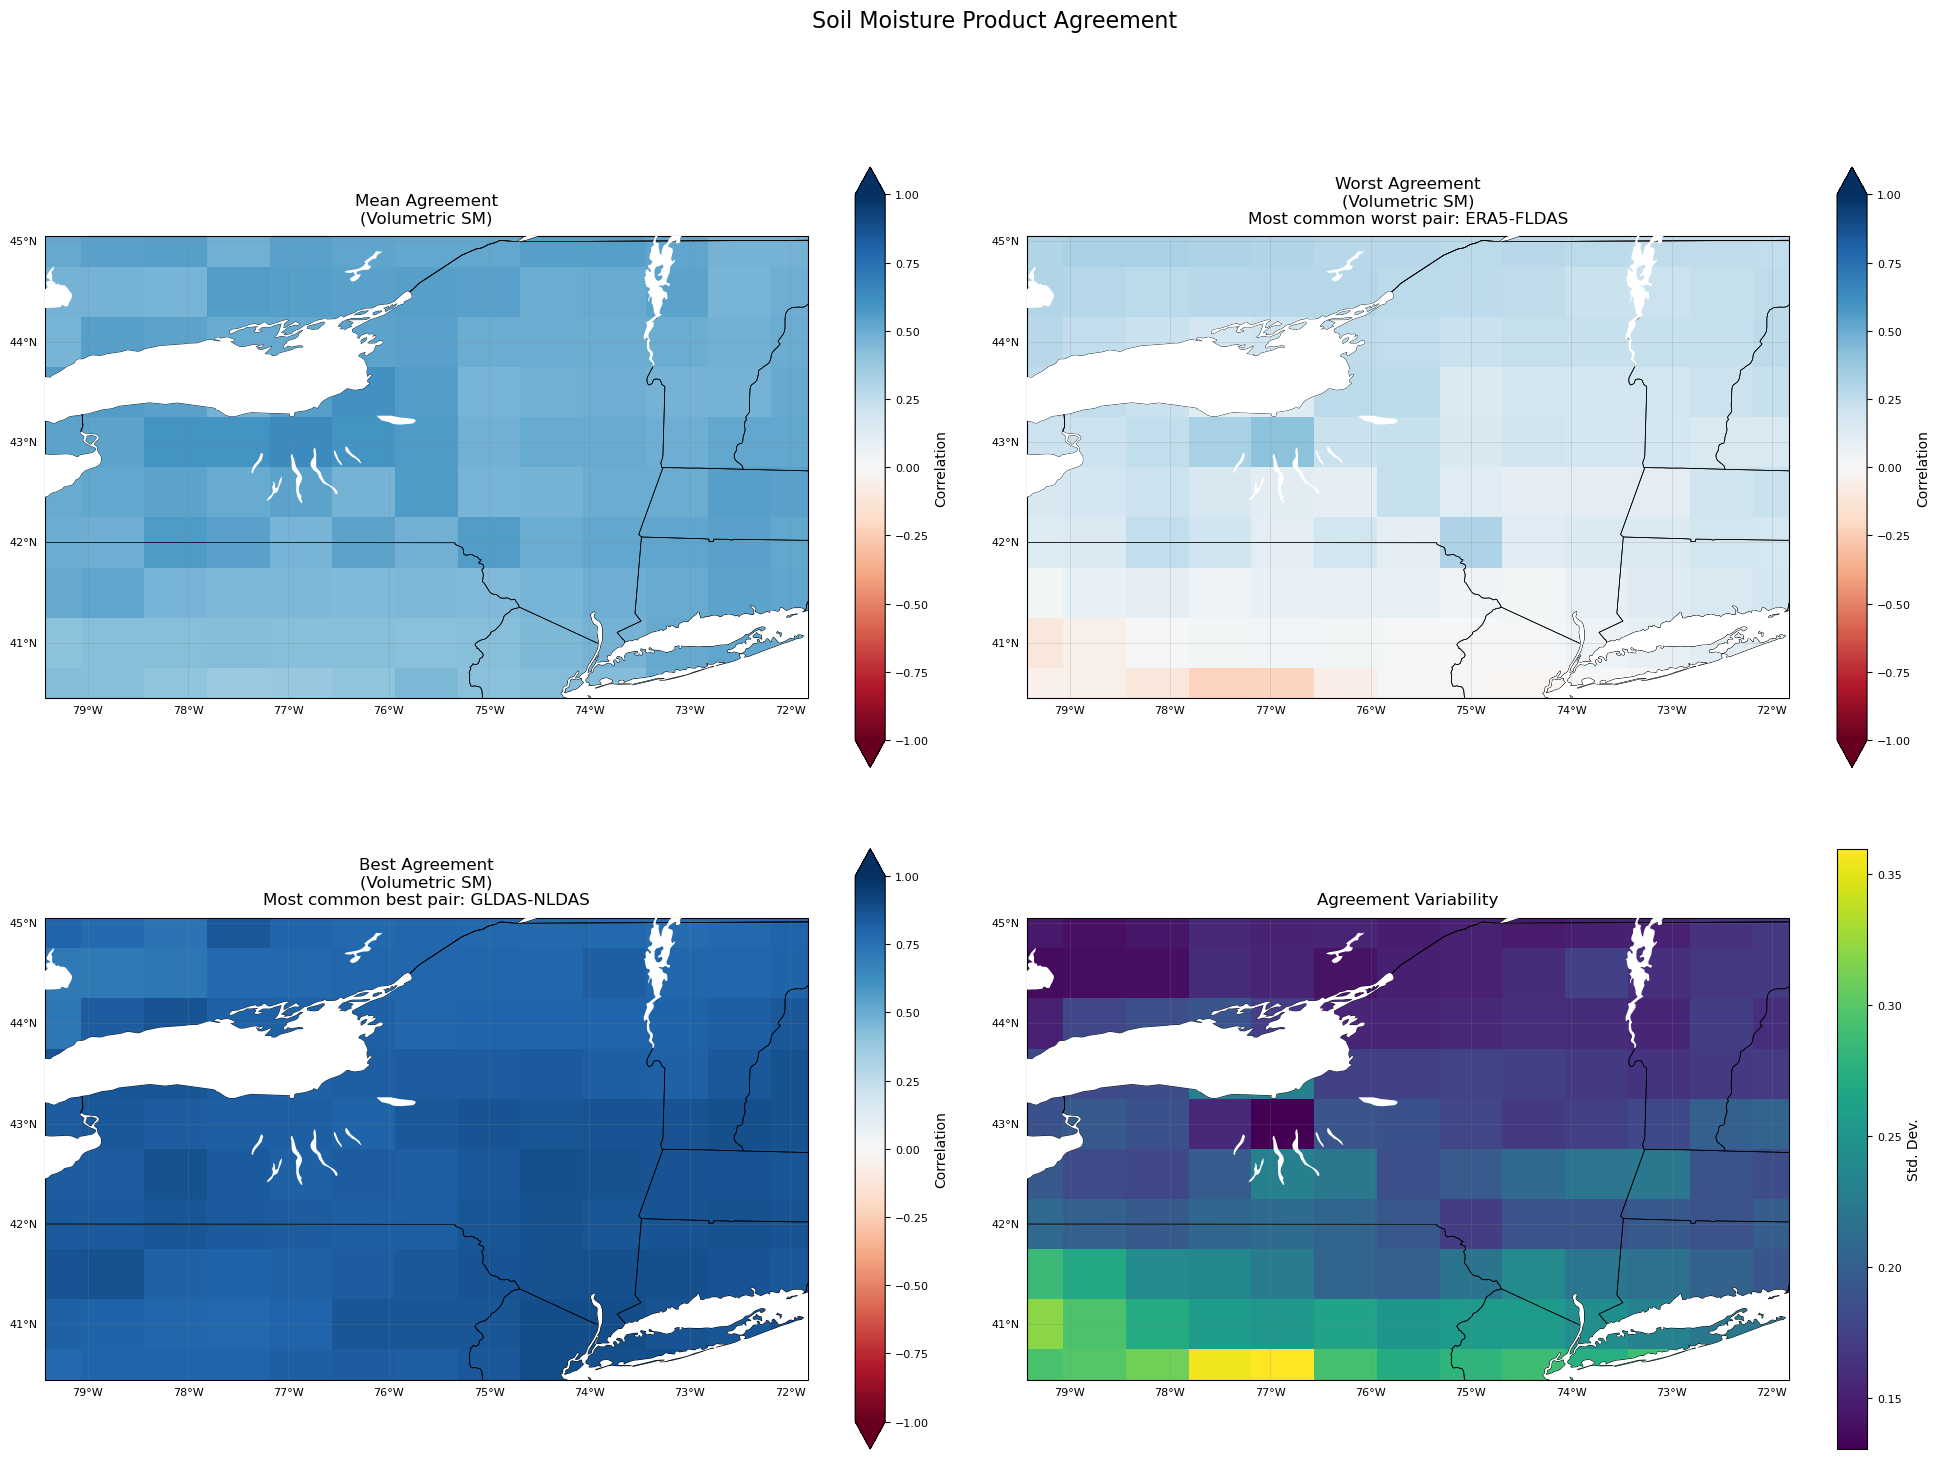


=== Overall Statistics ===

mean_correlation:
Mean: 0.499
Median: 0.500
Min: 0.368
Max: 0.634

max_correlation:
Mean: 0.829
Median: 0.830
Min: 0.718
Max: 0.893

min_correlation:
Mean: 0.160
Median: 0.185
Min: -0.232
Max: 0.407

correlation_std:
Mean: 0.201
Median: 0.188
Min: 0.130
Max: 0.360


In [24]:
def harmonize_units(data: xr.DataArray, name: str) -> xr.DataArray:
    """Convert soil moisture to volumetric units (m³/m³)"""
    if name in ['NLDAS', 'GLDAS']:
        depth = 0.1  # 10cm depth
        return data / (1000 * depth)  # Convert kg/m² to m³/m³
    return data

def calculate_spatial_agreement(datasets_dict):
    """Calculate spatial agreement metrics with harmonized units"""
    # First harmonize units
    harmonized_datasets = {}
    for name, data in datasets_dict.items():
        if isinstance(data, xr.Dataset):
            if name == 'MERRA2' and 'SFMC' in data:
                harmonized_datasets[name] = harmonize_units(data['SFMC'], name)
            elif name == 'NLDAS' and 'SoilM_0_10cm' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilM_0_10cm'], name)
            elif name == 'FLDAS' and 'SoilMoi00_10cm_tavg' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi00_10cm_tavg'], name)
            elif name == 'GLDAS' and 'SoilMoi0_10cm_inst' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi0_10cm_inst'], name)
            elif name == 'ERA5' and 'swvl1' in data:
                harmonized_datasets[name] = harmonize_units(data['swvl1'], name)
    
    # Calculate grid dimensions
    min_lat = min(data.shape[1] for data in harmonized_datasets.values())
    min_lon = min(data.shape[2] for data in harmonized_datasets.values())
    
    # Initialize arrays
    mean_correlation = np.zeros((min_lat, min_lon))
    max_correlation = np.zeros((min_lat, min_lon))
    min_correlation = np.zeros((min_lat, min_lon))
    correlation_std = np.zeros((min_lat, min_lon))
    best_pairs = np.empty((min_lat, min_lon), dtype='U20')
    worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
    
    # Calculate correlations
    for i in range(min_lat):
        for j in range(min_lon):
            correlations = []
            pairs = []
            
            for name1, data1 in harmonized_datasets.items():
                for name2, data2 in harmonized_datasets.items():
                    if name1 < name2:
                        try:
                            ts1 = data1[:, i, j]
                            ts2 = data2[:, i, j]
                            
                            d1 = ts1.values if hasattr(ts1, 'values') else ts1
                            d2 = ts2.values if hasattr(ts2, 'values') else ts2
                            
                            valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                            if valid_mask.any():
                                d1_valid = d1[valid_mask]
                                d2_valid = d2[valid_mask]
                                
                                if len(d1_valid) >= 2:
                                    corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                    if not np.isnan(corr):
                                        correlations.append(corr)
                                        pairs.append(f"{name1}-{name2}")
                        
                        except Exception as e:
                            continue
            
            if correlations:
                mean_correlation[i,j] = np.mean(correlations)
                max_idx = np.argmax(correlations)
                min_idx = np.argmin(correlations)
                max_correlation[i,j] = correlations[max_idx]
                min_correlation[i,j] = correlations[min_idx]
                correlation_std[i,j] = np.std(correlations)
                best_pairs[i,j] = pairs[max_idx]
                worst_pairs[i,j] = pairs[min_idx]
            else:
                mean_correlation[i,j] = np.nan
                max_correlation[i,j] = np.nan
                min_correlation[i,j] = np.nan
                correlation_std[i,j] = np.nan
    
    # Get coordinates
    ref_data = list(harmonized_datasets.values())[0]
    try:
        lats = ref_data.lat.values[:min_lat]
        lons = ref_data.lon.values[:min_lon]
    except AttributeError:
        try:
            lats = ref_data.latitude.values[:min_lat]
            lons = ref_data.longitude.values[:min_lon]
        except AttributeError:
            lats = np.arange(min_lat)
            lons = np.arange(min_lon)
    
    metrics = {
        'mean_correlation': xr.DataArray(
            mean_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'max_correlation': xr.DataArray(
            max_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'min_correlation': xr.DataArray(
            min_correlation,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'correlation_std': xr.DataArray(
            correlation_std,
            coords={'latitude': lats, 'longitude': lons},
            dims=['latitude', 'longitude']
        ),
        'best_pairs': best_pairs,
        'worst_pairs': worst_pairs
    }
    
    return metrics

def plot_spatial_agreement(metrics):
    """Create detailed spatial agreement plots"""
    fig = plt.figure(figsize=(20, 15))
    proj = ccrs.PlateCarree()
    
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    colors.reverse()
    cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
    
    plots = [
        ('mean_correlation', 'Mean Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('min_correlation', 'Worst Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('max_correlation', 'Best Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('correlation_std', 'Agreement Variability', 'viridis', 'Std. Dev.', False)
    ]
    
    for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        if metric == 'max_correlation':
            unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common best pair: {most_common}'
        elif metric == 'min_correlation':
            unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common worst pair: {most_common}'
        
        if use_correlation_range:
            data = metrics[metric].values
            valid_data = data[~np.isnan(data)]
            vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
            vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
            extend = 'both'
            center = 0
        else:
            vmin = None
            vmax = None
            extend = 'neither'
            center = None
        
        lons, lats = np.meshgrid(metrics[metric].longitude, metrics[metric].latitude)
        im = ax.pcolormesh(
            lons, lats,
            metrics[metric].values,
            transform=proj,
            cmap=colormap,
            vmin=vmin,
            vmax=vmax
        )
        
        cb = plt.colorbar(im, ax=ax, label=label, extend=extend, shrink=0.8)
        cb.set_label(label, size=10)
        cb.ax.tick_params(labelsize=8)
        
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        lon_min, lon_max = metrics[metric].longitude.min(), metrics[metric].longitude.max()
        lat_min, lat_max = metrics[metric].latitude.min(), metrics[metric].latitude.max()
        padding = 0.05
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        ax.set_title(title, pad=10, fontsize=12)
    
    plt.suptitle('Soil Moisture Product Agreement', fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

# Run analysis
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

metrics = calculate_spatial_agreement(datasets)
fig = plot_spatial_agreement(metrics)
plt.show()

# Print summary statistics
print("\n=== Overall Statistics ===")
for metric in ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']:
    data = metrics[metric].values
    valid_data = data[~np.isnan(data)]
    if len(valid_data) > 0:
        print(f"\n{metric}:")
        print(f"Mean: {np.mean(valid_data):.3f}")
        print(f"Median: {np.median(valid_data):.3f}")
        print(f"Min: {np.min(valid_data):.3f}")
        print(f"Max: {np.max(valid_data):.3f}")


Decomposed MERRA2 into seasons

Decomposed NLDAS into seasons

Decomposed FLDAS into seasons

Decomposed GLDAS into seasons

Decomposed ERA5 into seasons

Processing Winter

Processing Spring

Processing Summer

Processing Fall


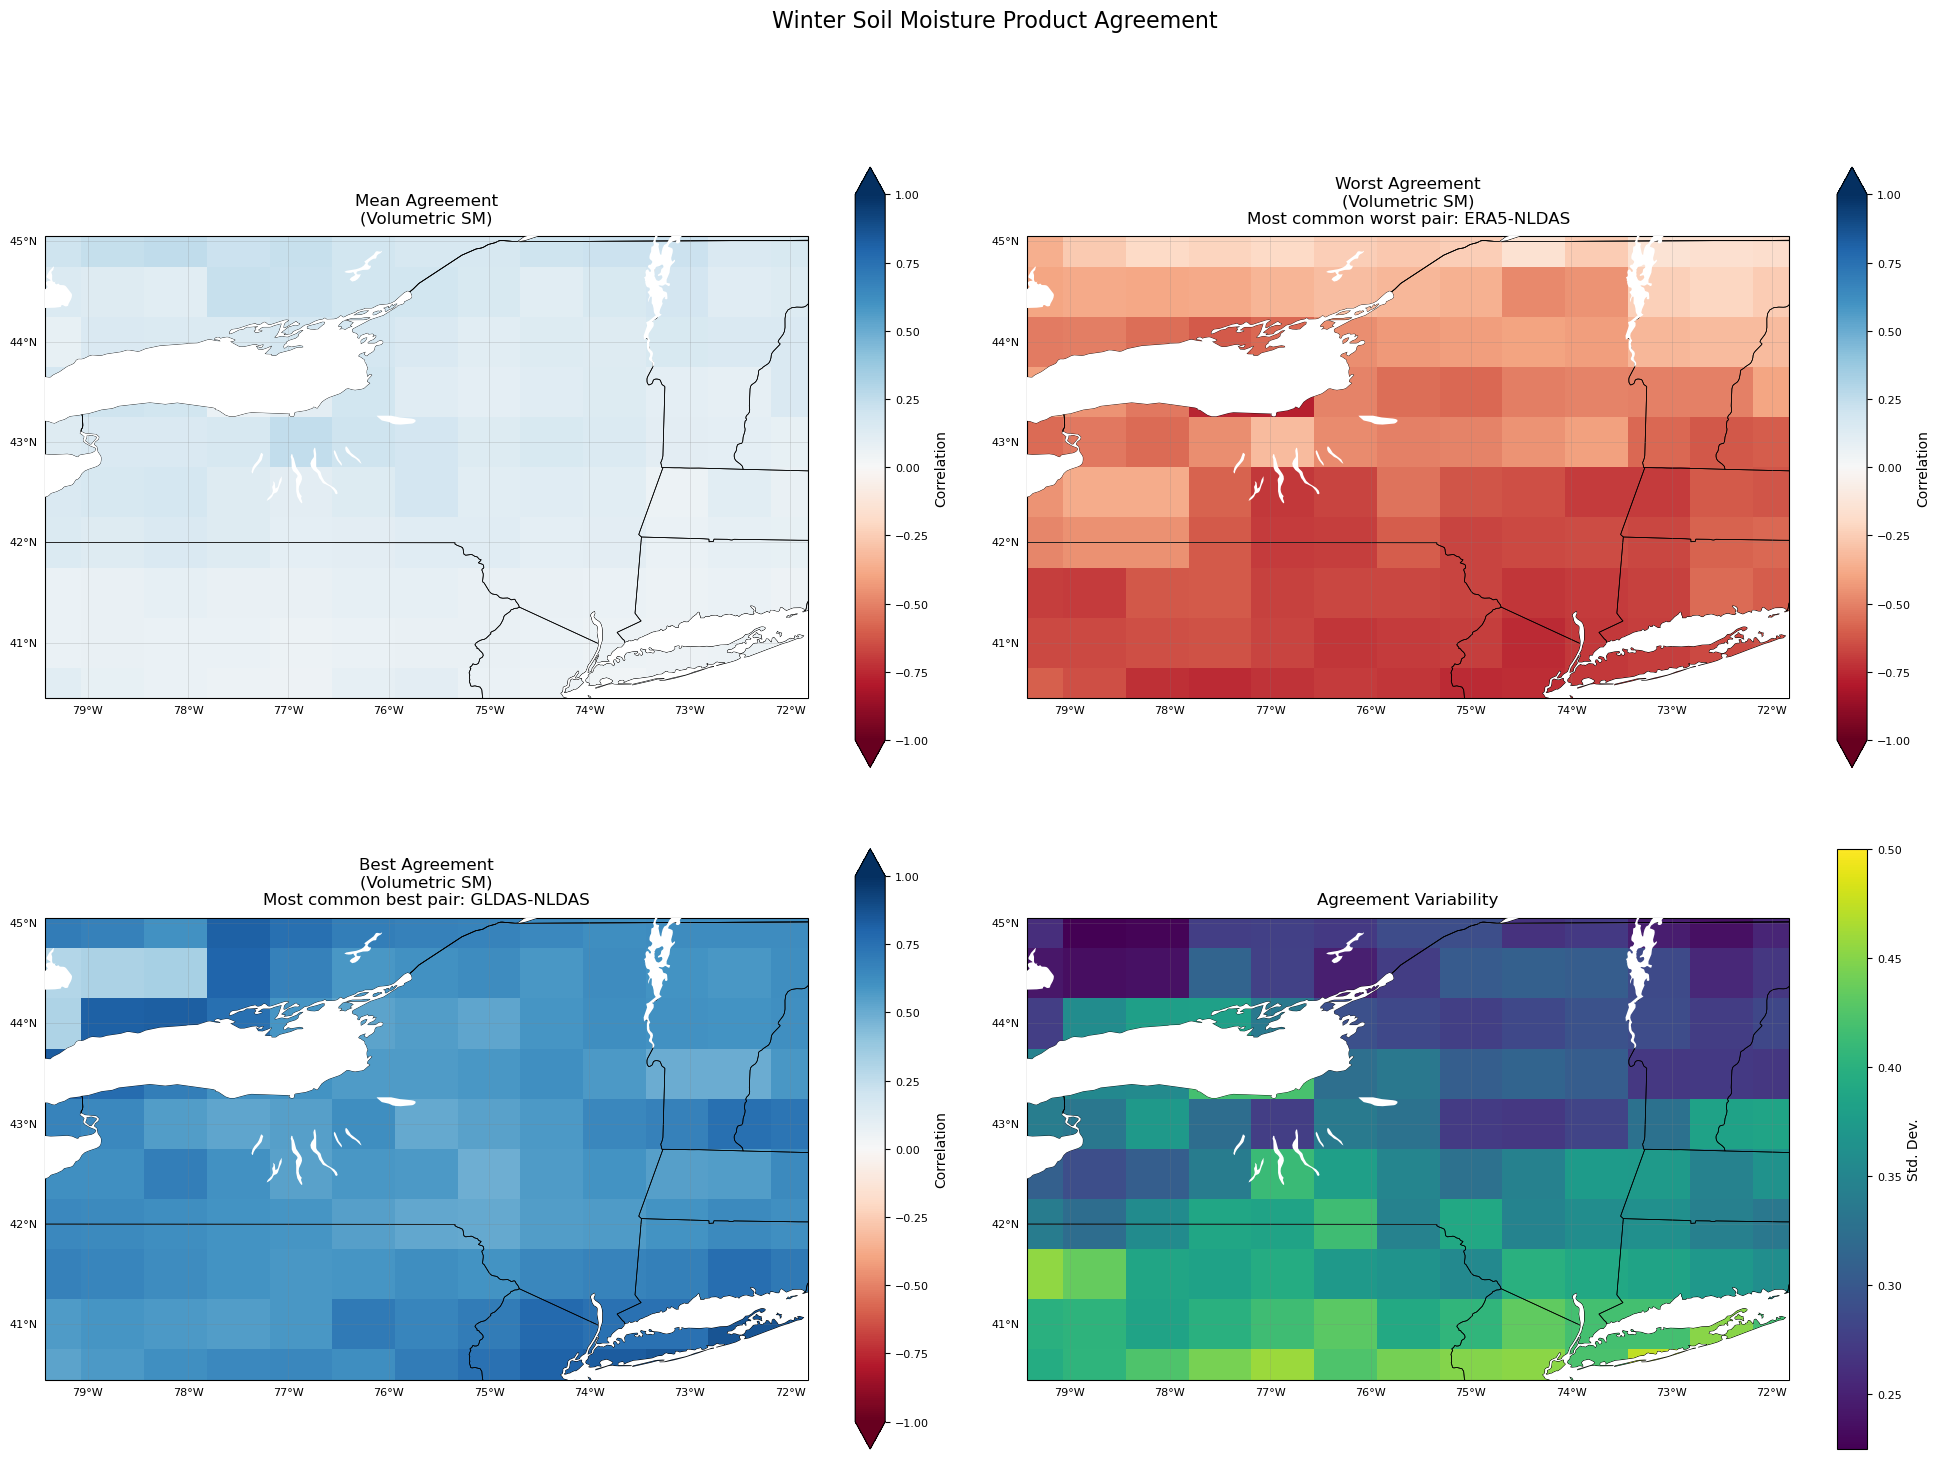


=== Winter Statistics ===

mean_correlation:
Mean: 0.123
Median: 0.118
Min: 0.030
Max: 0.256

max_correlation:
Mean: 0.630
Median: 0.614
Min: 0.296
Max: 0.891

min_correlation:
Mean: -0.529
Median: -0.570
Min: -0.775
Max: -0.145

correlation_std:
Mean: 0.345
Median: 0.347
Min: 0.225
Max: 0.500


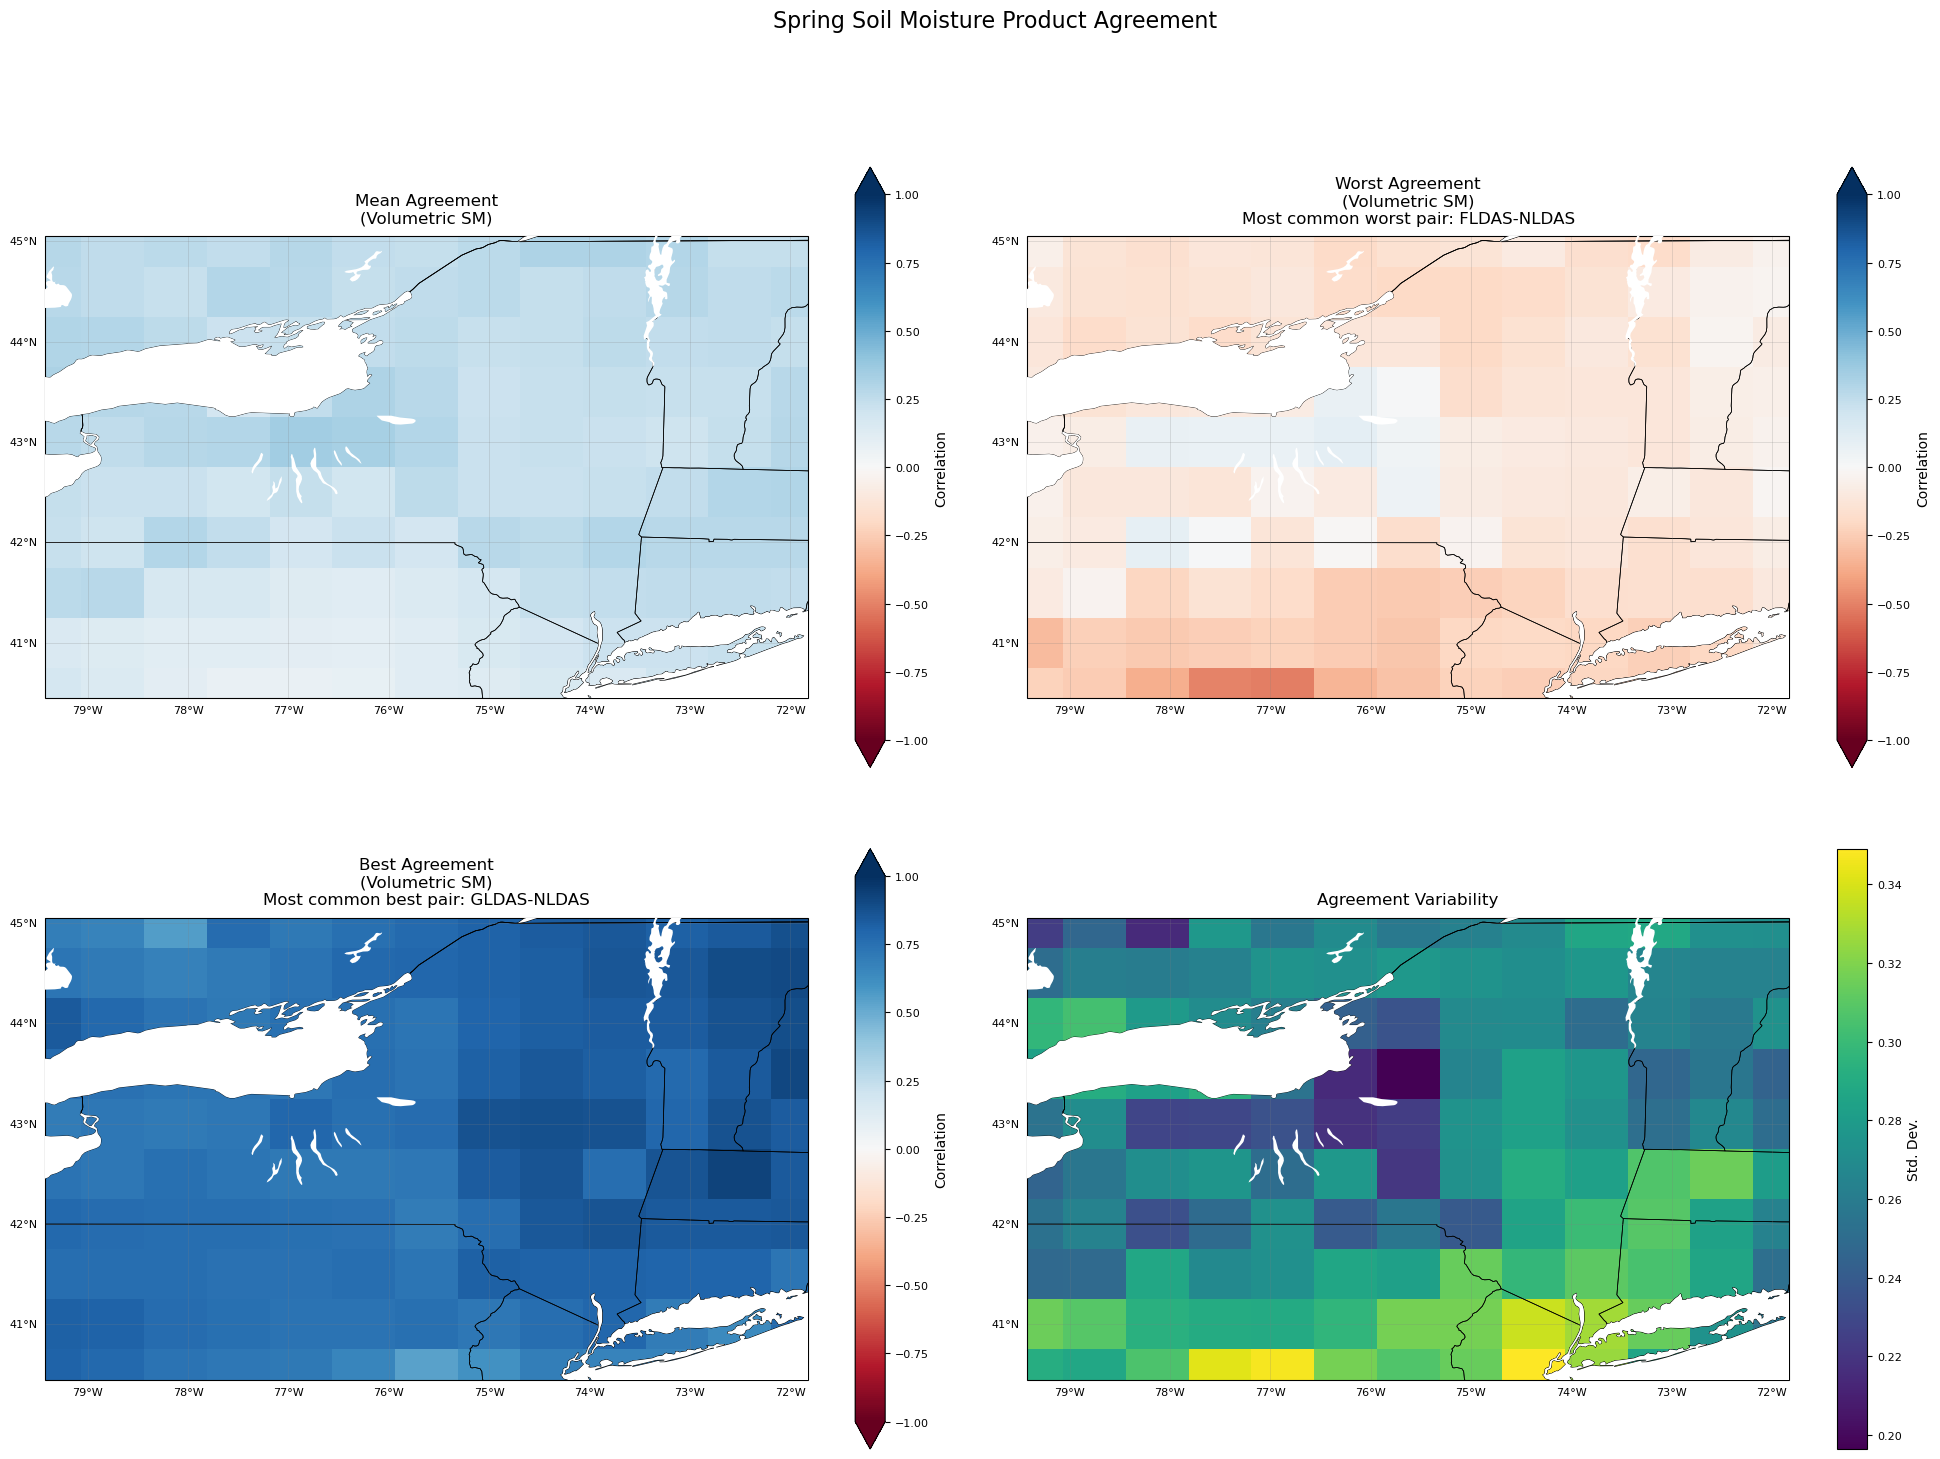


=== Spring Statistics ===

mean_correlation:
Mean: 0.229
Median: 0.241
Min: 0.071
Max: 0.349

max_correlation:
Mean: 0.772
Median: 0.763
Min: 0.539
Max: 0.924

min_correlation:
Mean: -0.136
Median: -0.127
Min: -0.511
Max: 0.095

correlation_std:
Mean: 0.274
Median: 0.273
Min: 0.196
Max: 0.349


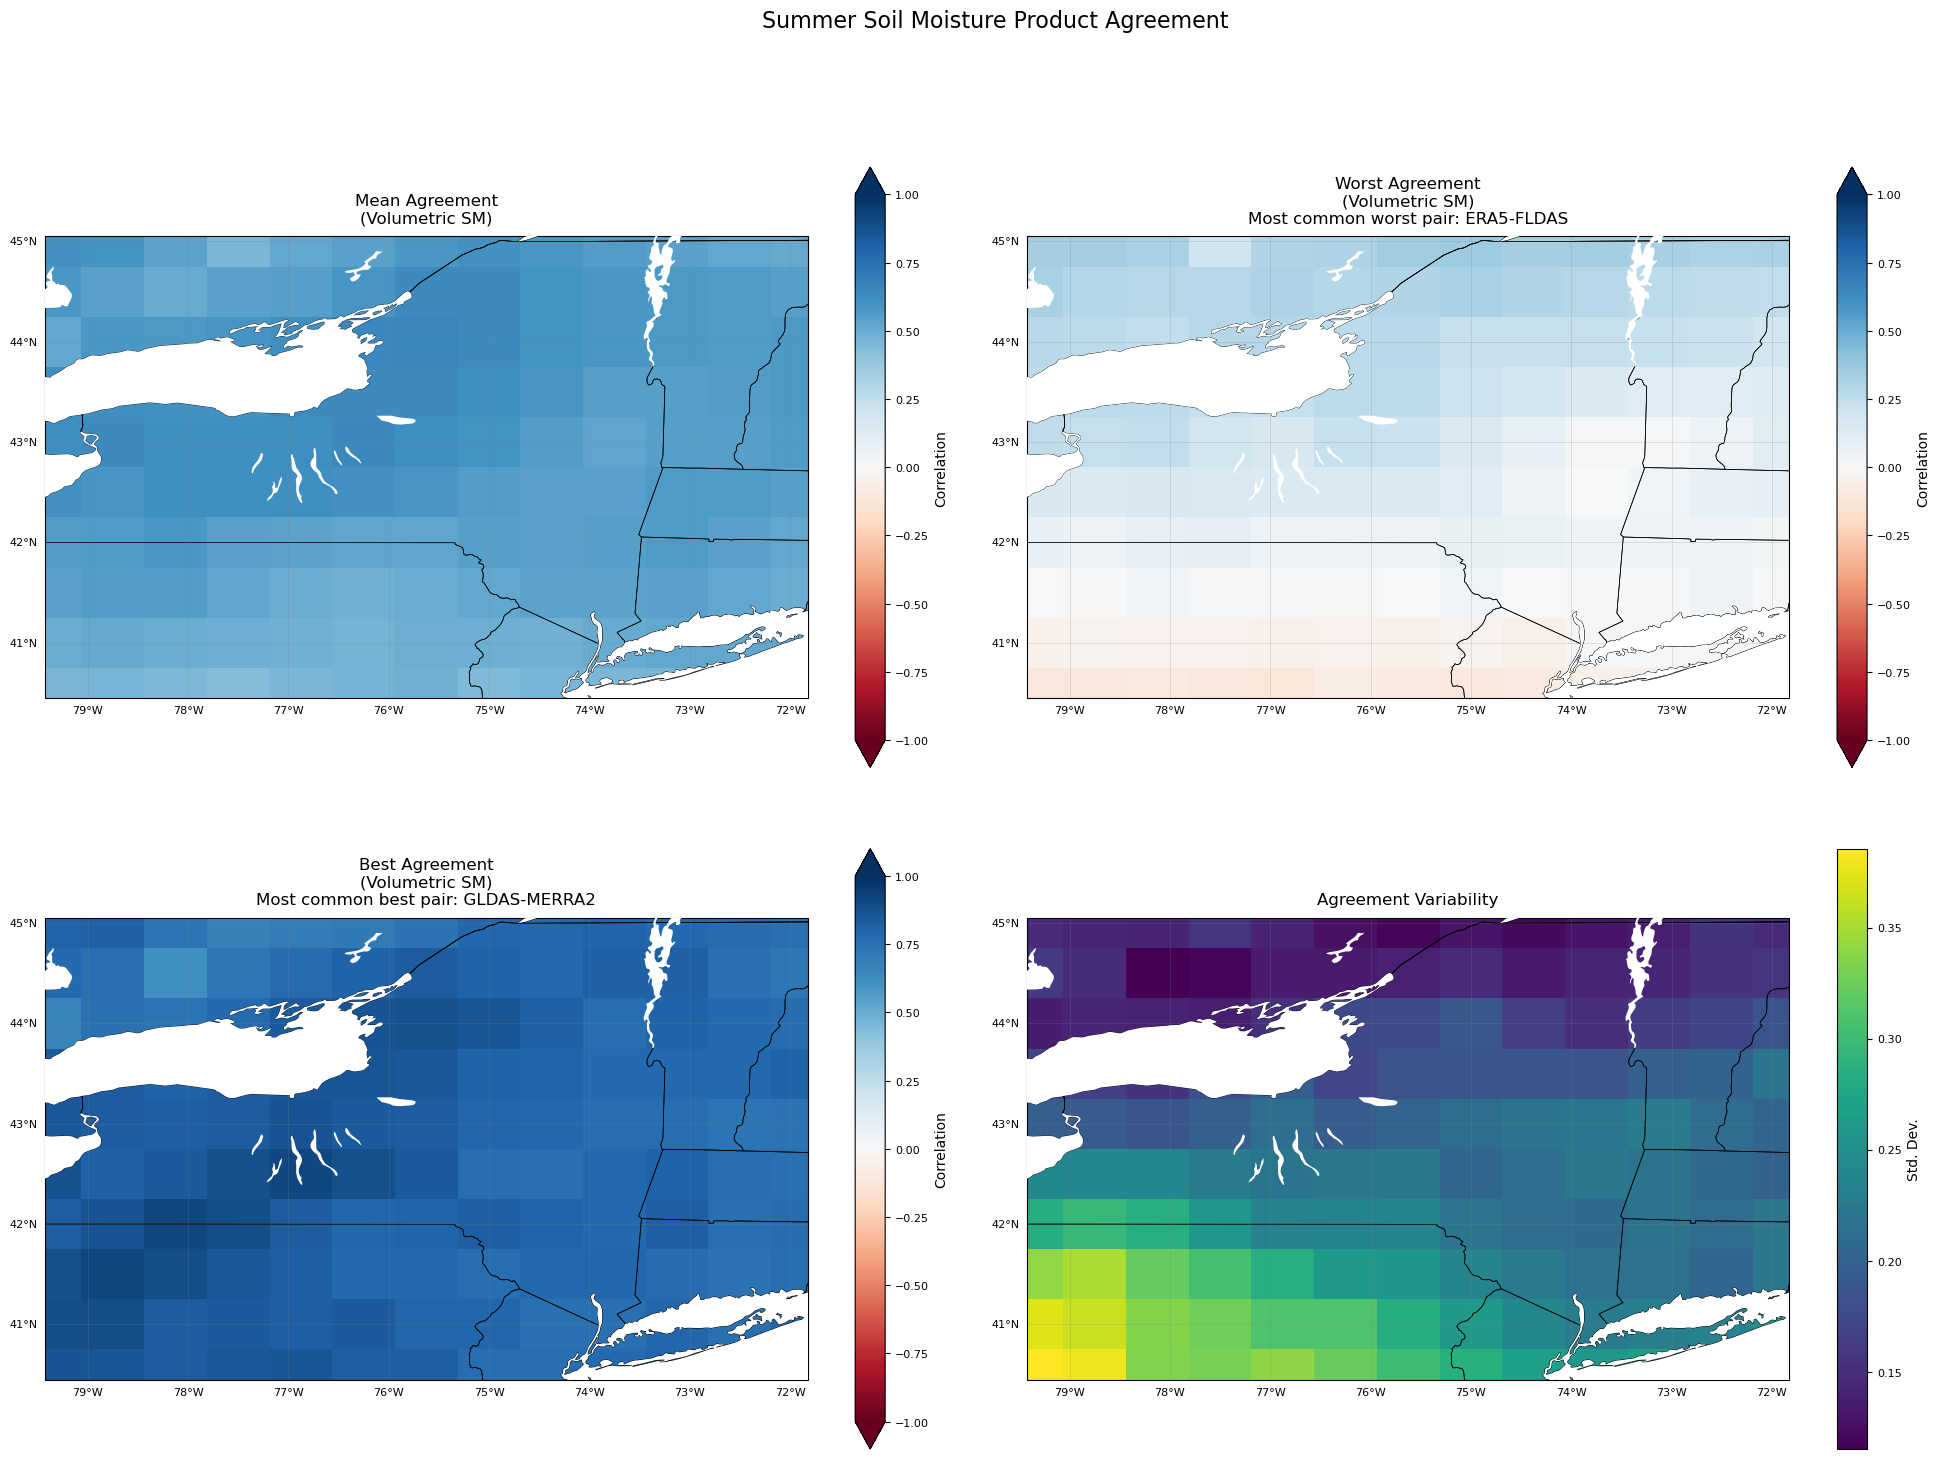


=== Summer Statistics ===

mean_correlation:
Mean: 0.552
Median: 0.553
Min: 0.432
Max: 0.650

max_correlation:
Mean: 0.801
Median: 0.799
Min: 0.613
Max: 0.921

min_correlation:
Mean: 0.129
Median: 0.128
Min: -0.118
Max: 0.360

correlation_std:
Mean: 0.215
Median: 0.210
Min: 0.115
Max: 0.385


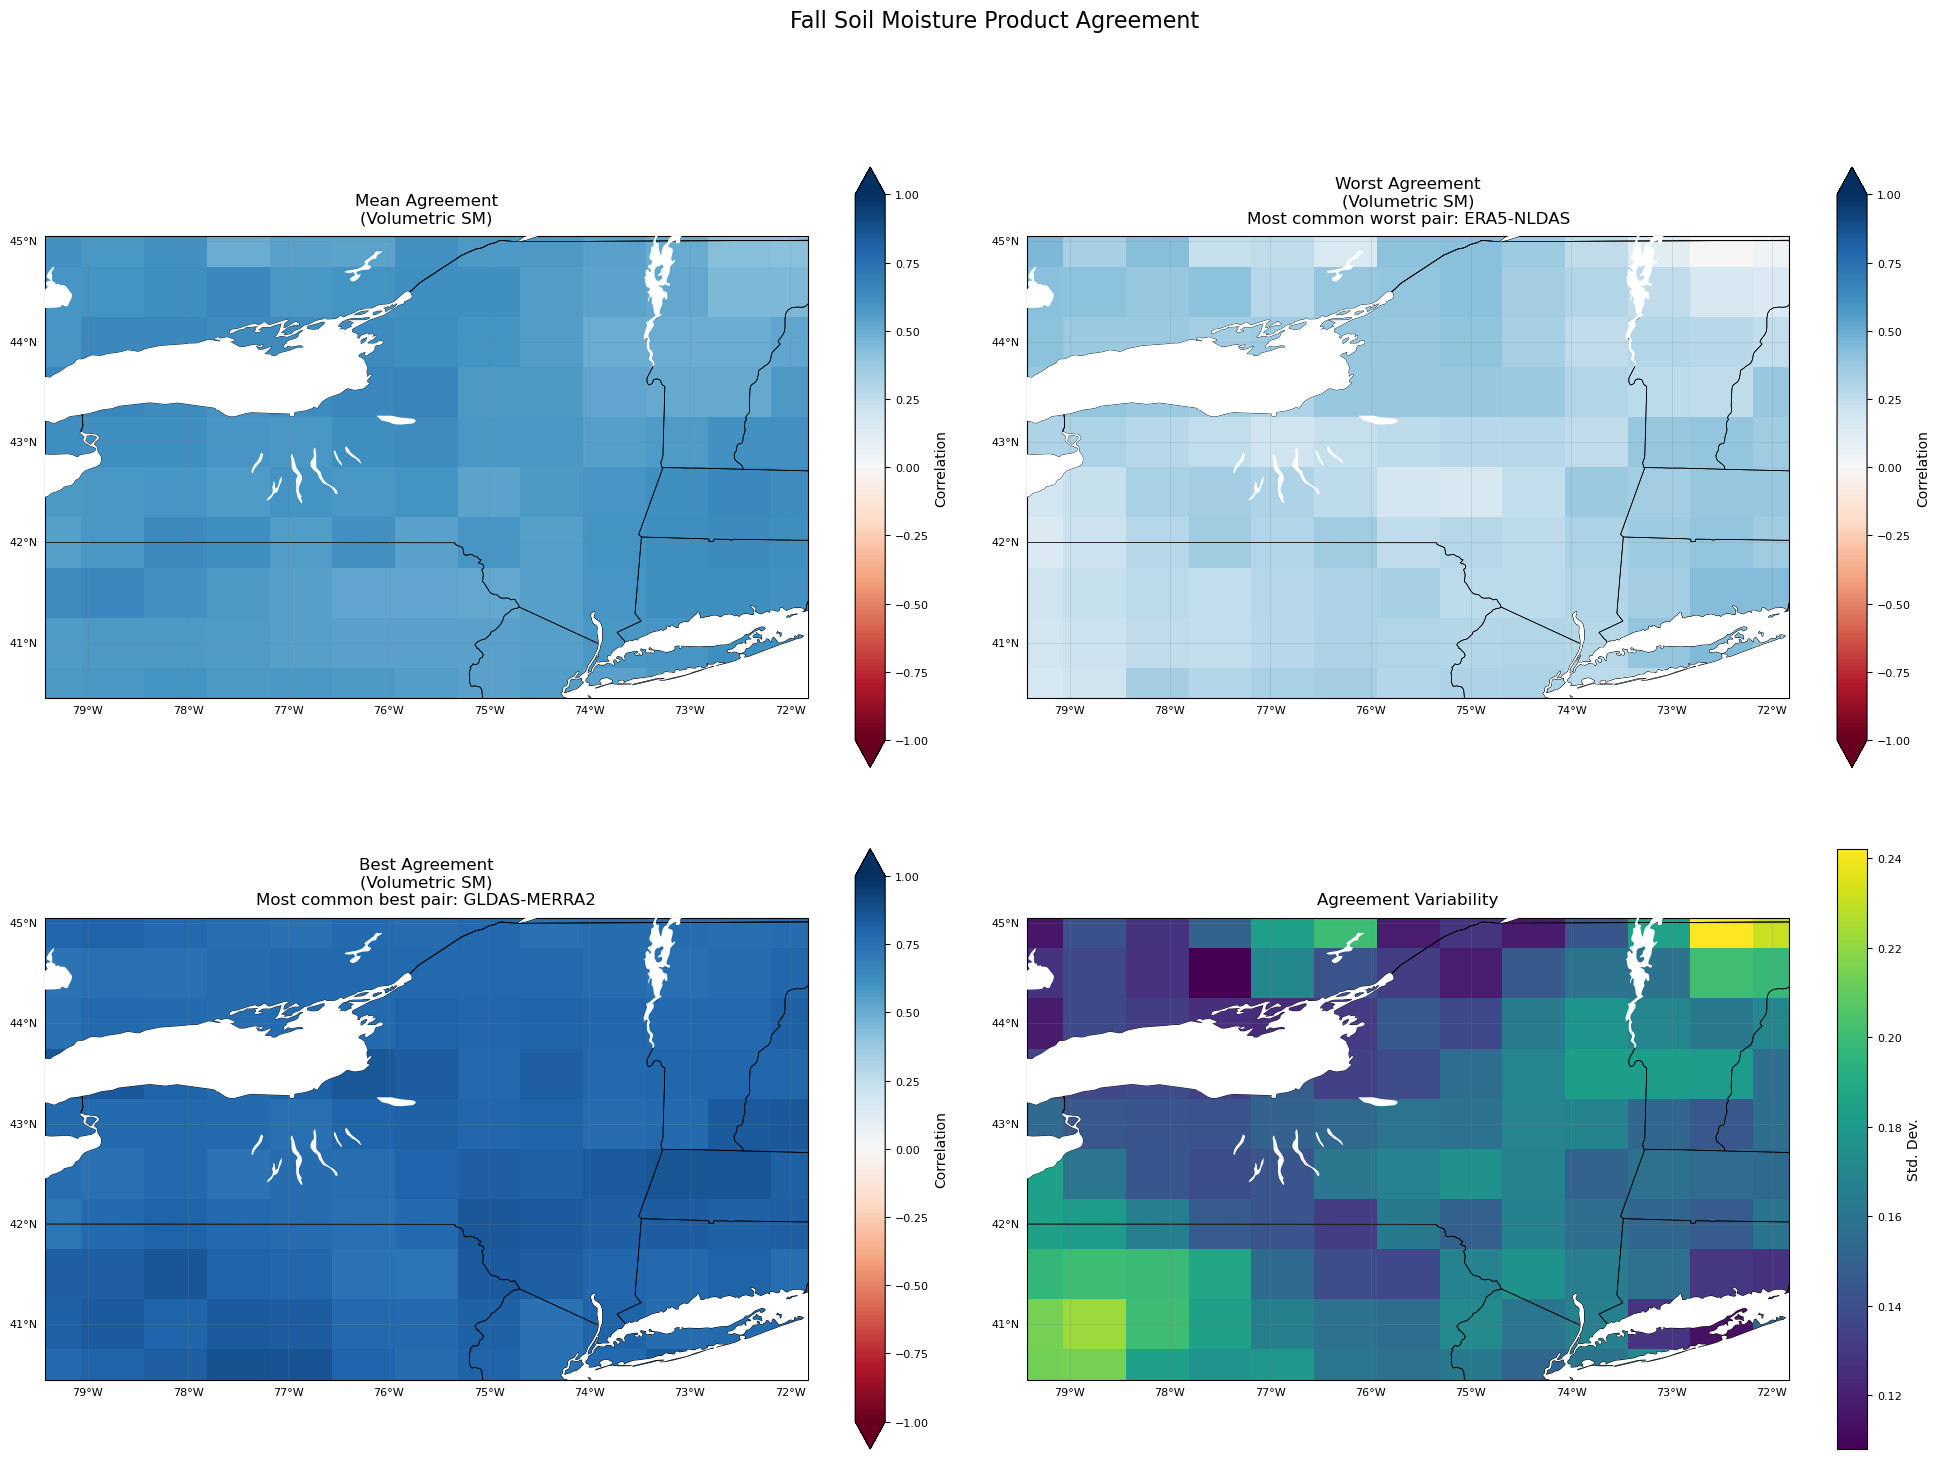


=== Fall Statistics ===

mean_correlation:
Mean: 0.579
Median: 0.581
Min: 0.421
Max: 0.660

max_correlation:
Mean: 0.794
Median: 0.789
Min: 0.719
Max: 0.874

min_correlation:
Mean: 0.305
Median: 0.306
Min: -0.012
Max: 0.453

correlation_std:
Mean: 0.158
Median: 0.157
Min: 0.108
Max: 0.242


In [23]:
#decompose into seasons and plot all 4 spatial agreement again 

def harmonize_units(data: xr.DataArray, name: str) -> xr.DataArray:
    """Convert soil moisture to volumetric units (m³/m³)"""
    if name in ['NLDAS', 'GLDAS']:
        depth = 0.1  # 10cm depth
        return data / (1000 * depth)  # Convert kg/m² to m³/m³
    return data

def get_season(month):
    """Convert month number to season name"""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

def decompose_by_season(data):
    """Split data into seasonal components"""
    if isinstance(data, xr.Dataset):
        if 'SFMC' in data:
            data = data['SFMC']
        elif 'SoilM_0_10cm' in data:
            data = data['SoilM_0_10cm']
        elif 'SoilMoi00_10cm_tavg' in data:
            data = data['SoilMoi00_10cm_tavg']
        elif 'SoilMoi0_10cm_inst' in data:
            data = data['SoilMoi0_10cm_inst']
        elif 'swvl1' in data:
            data = data['swvl1']
    
    months = pd.DatetimeIndex(data.time.values).month
    seasons = [get_season(m) for m in months]
    
    seasonal_data = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_mask = [s == season for s in seasons]
        seasonal_data[season] = data.isel(time=season_mask)
    
    return seasonal_data

def calculate_seasonal_metrics(datasets_dict):
    """Calculate seasonal metrics with harmonized units"""
    # First harmonize units
    harmonized_datasets = {}
    for name, data in datasets_dict.items():
        if isinstance(data, xr.Dataset):
            if name == 'MERRA2' and 'SFMC' in data:
                harmonized_datasets[name] = harmonize_units(data['SFMC'], name)
            elif name == 'NLDAS' and 'SoilM_0_10cm' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilM_0_10cm'], name)
            elif name == 'FLDAS' and 'SoilMoi00_10cm_tavg' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi00_10cm_tavg'], name)
            elif name == 'GLDAS' and 'SoilMoi0_10cm_inst' in data:
                harmonized_datasets[name] = harmonize_units(data['SoilMoi0_10cm_inst'], name)
            elif name == 'ERA5' and 'swvl1' in data:
                harmonized_datasets[name] = harmonize_units(data['swvl1'], name)
    
    # Split into seasons
    seasonal_datasets = {}
    for name, data in harmonized_datasets.items():
        seasonal_datasets[name] = decompose_by_season(data)
        print(f"\nDecomposed {name} into seasons")
    
    seasonal_metrics = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        print(f"\nProcessing {season}")
        
        season_data = {}
        for name in harmonized_datasets.keys():
            season_data[name] = seasonal_datasets[name][season]
        
        # Calculate grid dimensions
        min_lat = min(data.shape[1] for data in season_data.values())
        min_lon = min(data.shape[2] for data in season_data.values())
        
        # Initialize arrays
        mean_correlation = np.zeros((min_lat, min_lon))
        max_correlation = np.zeros((min_lat, min_lon))
        min_correlation = np.zeros((min_lat, min_lon))
        correlation_std = np.zeros((min_lat, min_lon))
        best_pairs = np.empty((min_lat, min_lon), dtype='U20')
        worst_pairs = np.empty((min_lat, min_lon), dtype='U20')
        
        # Calculate correlations
        for i in range(min_lat):
            for j in range(min_lon):
                correlations = []
                pairs = []
                
                for name1, data1 in season_data.items():
                    for name2, data2 in season_data.items():
                        if name1 < name2:
                            try:
                                ts1 = data1[:, i, j]
                                ts2 = data2[:, i, j]
                                
                                d1 = ts1.values if hasattr(ts1, 'values') else ts1
                                d2 = ts2.values if hasattr(ts2, 'values') else ts2
                                
                                valid_mask = ~(np.isnan(d1) | np.isnan(d2))
                                if valid_mask.any():
                                    d1_valid = d1[valid_mask]
                                    d2_valid = d2[valid_mask]
                                    
                                    if len(d1_valid) >= 2:
                                        corr = np.corrcoef(d1_valid, d2_valid)[0,1]
                                        if not np.isnan(corr):
                                            correlations.append(corr)
                                            pairs.append(f"{name1}-{name2}")
                            
                            except Exception as e:
                                continue
                
                if correlations:
                    mean_correlation[i,j] = np.mean(correlations)
                    max_idx = np.argmax(correlations)
                    min_idx = np.argmin(correlations)
                    max_correlation[i,j] = correlations[max_idx]
                    min_correlation[i,j] = correlations[min_idx]
                    correlation_std[i,j] = np.std(correlations)
                    best_pairs[i,j] = pairs[max_idx]
                    worst_pairs[i,j] = pairs[min_idx]
                else:
                    mean_correlation[i,j] = np.nan
                    max_correlation[i,j] = np.nan
                    min_correlation[i,j] = np.nan
                    correlation_std[i,j] = np.nan
        
        # Get coordinates
        ref_data = season_data['MERRA2']
        try:
            lats = ref_data.lat.values[:min_lat]
            lons = ref_data.lon.values[:min_lon]
        except AttributeError:
            try:
                lats = ref_data.latitude.values[:min_lat]
                lons = ref_data.longitude.values[:min_lon]
            except AttributeError:
                lats = np.arange(min_lat)
                lons = np.arange(min_lon)
        
        seasonal_metrics[season] = {
            'mean_correlation': xr.DataArray(
                mean_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'max_correlation': xr.DataArray(
                max_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'min_correlation': xr.DataArray(
                min_correlation,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'correlation_std': xr.DataArray(
                correlation_std,
                coords={'latitude': lats, 'longitude': lons},
                dims=['latitude', 'longitude']
            ),
            'best_pairs': best_pairs,
            'worst_pairs': worst_pairs
        }
    
    return seasonal_metrics

def plot_season_detailed(metrics, season):
    """Create detailed seasonal plots with proper units and enhanced visibility"""
    fig = plt.figure(figsize=(20, 15))
    proj = ccrs.PlateCarree()
    
    colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
              '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
    colors.reverse()
    cmap = LinearSegmentedColormap.from_list('custom_blue_red', colors)
    
    plots = [
        ('mean_correlation', 'Mean Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('min_correlation', 'Worst Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('max_correlation', 'Best Agreement\n(Volumetric SM)', cmap, 'Correlation', True),
        ('correlation_std', 'Agreement Variability', 'viridis', 'Std. Dev.', False)
    ]
    
    for idx, (metric, title, colormap, label, use_correlation_range) in enumerate(plots, 1):
        ax = fig.add_subplot(2, 2, idx, projection=proj)
        
        # Add gridlines with enhanced visibility
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.3, color='gray')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
        if metric == 'max_correlation':
            unique_pairs, counts = np.unique(metrics['best_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common best pair: {most_common}'
        elif metric == 'min_correlation':
            unique_pairs, counts = np.unique(metrics['worst_pairs'], return_counts=True)
            most_common = unique_pairs[np.argmax(counts)]
            title += f'\nMost common worst pair: {most_common}'
        
        if use_correlation_range:
            data = metrics[metric].values
            valid_data = data[~np.isnan(data)]
            vmin = min(-1, np.min(valid_data)) if len(valid_data) > 0 else -1
            vmax = max(1, np.max(valid_data)) if len(valid_data) > 0 else 1
            extend = 'both'
            center = 0
        else:
            vmin = None
            vmax = None
            extend = 'neither'
            center = None
        
        # Direct pcolormesh plotting instead of xarray's plot method
        lons, lats = np.meshgrid(metrics[metric].longitude, metrics[metric].latitude)
        im = ax.pcolormesh(
            lons, lats,
            metrics[metric].values,
            transform=proj,
            cmap=colormap,
            vmin=vmin,
            vmax=vmax
        )
        
        # Add colorbar
        cb = plt.colorbar(im, ax=ax, label=label, extend=extend, shrink=0.8)
        cb.set_label(label, size=10)
        cb.ax.tick_params(labelsize=8)
        
        # Enhanced map features
        ax.add_feature(cfeature.OCEAN.with_scale('10m'), zorder=100,facecolor='white')
        ax.add_feature(cfeature.LAKES.with_scale('10m'), zorder=100, facecolor='white')
        ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black', linewidth=0.5)
        
        # Set extent with minimal padding
        lon_min, lon_max = metrics[metric].longitude.min(), metrics[metric].longitude.max()
        lat_min, lat_max = metrics[metric].latitude.min(), metrics[metric].latitude.max()
        padding = 0.05  # Reduced padding
        ax.set_extent([
            lon_min - padding,
            lon_max + padding,
            lat_min - padding,
            lat_max + padding
        ], crs=proj)
        
        ax.set_title(title, pad=10, fontsize=12)
    
    plt.suptitle(f'{season} Soil Moisture Product Agreement', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    return fig

def analyze_seasonal_patterns(datasets):
    """Run complete seasonal analysis"""
    # Calculate seasonal metrics
    seasonal_metrics = calculate_seasonal_metrics(datasets)
    
    # Create separate plots for each season
    season_figs = {}
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        # Create and display plot
        fig = plot_season_detailed(seasonal_metrics[season], season)
        season_figs[season] = fig
        plt.show()
        
        # Print summary statistics for this season
        print(f"\n=== {season} Statistics ===")
        for metric in ['mean_correlation', 'max_correlation', 'min_correlation', 'correlation_std']:
            data = seasonal_metrics[season][metric].values
            valid_data = data[~np.isnan(data)]
            if len(valid_data) > 0:
                print(f"\n{metric}:")
                print(f"Mean: {np.mean(valid_data):.3f}")
                print(f"Median: {np.median(valid_data):.3f}")
                print(f"Min: {np.min(valid_data):.3f}")
                print(f"Max: {np.max(valid_data):.3f}")
    
    return seasonal_metrics, season_figs
# Run analysis
datasets = {
    'MERRA2': merra2_data,
    'NLDAS': nldas_data,
    'FLDAS': fldas_data,
    'GLDAS': gldas_data,
    'ERA5': era5_data
}

metrics, figures = analyze_seasonal_patterns(datasets)